In [1]:
import glob
import os
from readfiles import *
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import h5py
from lomapost import * #All functions defined within module lomapost
%matplotlib inline

In [2]:
set_fig_props()

In [3]:
from IPython.display import clear_output
from IPython.display import Image

# Job selection

In [4]:
p_results   = '/share/drive/toni/VDML/'          #Define path to folder with all results
#l_folders = os.listdir(p_results) #print available jobs (folders)
p_folders   = [p_results+ 's10/02/h5.stats',p_results+ 's20/01/h5.stats',p_results+ 's40/01/h5.stats',\
    p_results+ 's80/02/h5.stats']
#p_folders   = [p_results+ 'Re160s80/case1/h5.stats',p_results+ 'Re160s80/case2/h5.stats',p_results+ 'Re160s80/case3/h5.stats',\
#    p_results+ 'Re160s80/case1/y2/h5.stats',p_results+ 'Re160s80/case2/y2/h5.stats',p_results+ 'Re160s80/case3/y2/h5.stats']
njobs = len(p_folders) 
#define option and styles for sta reading

In [5]:
lgroup = [0,1 ,2,3];
laverage = [1,1,1,1] # Says which to average

In [6]:
def getaverageintime(p_folders,variable,tmin,tmax,Npoints=200,derivative=False):
    """
    for a given folder path, and variable,computes a interpolated function in time(tmin:tmax)
    and average for all folders given in p_folders.
    """
    njobs = len(p_folders)
    time_int = np.linspace(tmin,tmax,Npoints)
    #faverage = np.zeros(Npoints)
    ftoaverage= np.zeros([njobs,Npoints])
    for ijob in range(njobs):
        path = p_folders[ijob]
        with h5py.File(path,"r") as f:
            time = f['time'];
            fun1 = np.interp(time_int,time,f[variable])
            ftoaverage[ijob,:] = np.array(fun1)
            if derivative==True:
                ftoaverage[ijob,:]=der1(time_int,np.array(fun1))
    
    return time_int,np.mean(ftoaverage,axis=0),np.std(ftoaverage,axis=0)

In [7]:
def fcaseintime(p_folders,lcases,variable,tmin,tmax,Npoints=200,derivative=False):
    """
    using getaveragintime, returns as many vectors as cases wanted to compute.
    Distribution of cases is given in lcases(ex. lcases = [[0,1,2],[3,5]])
    """
    ncases = len(lcases)
    vtcases = [[] for i in range(ncases)]
    vfcases = [[] for i in range(ncases)]
    stddcases = [[] for i in range(ncases)]
    for icase in range(ncases):
        vpcases = []
        for ijob in lcases[icase]:
            vpcases = vpcases + [p_folders[ijob]]
        vtcases[icase],vfcases[icase],stddcases[icase] = getaverageintime(vpcases,variable,tmin,tmax,Npoints,derivative)
    return vtcases,vfcases,stddcases

In [8]:
def getvarmeanintime(path,variable,tmin,tmax,derivative=False):
    """
    for a given folder path, and variable,computes a interpolated function in time(tmin:tmax)
    and average for all folders given in p_folders.
    """
    with h5py.File(path,"r") as f:
            time = np.array(f['time']);
            if derivative==False:
                fun = np.array(f[variable])
            else: #Derivative with time
                fun = der1(time,np.array(f[variable]))
            it1 = where(time>=tmin)[0][0]
            it2 = where(time>=tmax)[0][0]
            mean = np.mean(fun[it1:it2]);
            error = np.std(fun[it1:it2]);
    return mean,error

In [9]:
der1?

In [10]:
def getSSprofile(path,variable,tmin,tmax,scaling = 'dm',Npoints=500,derivative=False,y0=0):
    """
    Obtain SS profile averaged in the given time
    """
    lim = 12.0;
    if scaling == 'dw':
        lim=2.0
    
    ydelta = np.linspace(-lim,lim,Npoints)
    funintcum = np.zeros(Npoints);
    nacum = 0
    with h5py.File(path,"r") as f:
        time = np.array(f['time']);
        fun = np.array(f[variable]);
        if variable=='rum':
            rhom = np.array(f['rhom'])
            fun = np.divide(fun,rhom)
            #print "computed rum/rhom"
        y = np.array(f['y'])
        delta = f[scaling]
        it1 = where(time>=tmin)[0][0]
        it2 = where(time>=tmax)[0][0]
        fyjob = [np.zeros(Npoints) for i in range(it2-it1)]
        print it1,it2
        for itime in range(it1,it2):
            dd = delta[itime]
            if derivative == True:
                funint = np.interp(ydelta,(y-y0)/dd,dd*der1(y,fun[:,itime]))
                if itime==it1:
                    print "Taking derivative and multiplying by scaling"
            else:
                if variable=='w3m' or variable[0:2] =='ep':
                    funint = np.interp(ydelta,(y-y0)/dd,dd*fun[:,itime])
                    if itime==it1: #First time
                        print "Multiplying by scaling"
                else:
                    funint = np.interp(ydelta,(y-y0)/dd,fun[:,itime])
            fyjob[itime-it1] = funint
            
    return ydelta,np.mean(fyjob,axis=0),np.std(fyjob,axis=0)
            

In [11]:
def pcolorintime(path,variable,tmin,tmax,scaling = 'dm',Npoints=500,derivative=False,y0=0):
    """
    Plot pcolor in time
    """
    lim = 12.0;
    if scaling == 'dw':
        lim=2.0
    
    ydelta = np.linspace(-lim,lim,Npoints)
    funintcum = np.zeros(Npoints);
    nacum = 0
    with h5py.File(path,"r") as f:
        time = np.array(f['time']);
        it1=where(time>=tmin)[0][0]
        it2=where(time>=tmax)[0][0]
        fun = np.array(f[variable]);
        if variable=='rum':
            rhom = np.array(f['rhom'])
            fun = np.divide(fun,rhom)
            #print "computed rum/rhom"
        y = np.array(f['y'])
        delta = np.array(f[scaling])
        fyjob = [np.zeros(Npoints) for i in range(it2-it1)]
        for itime in range(it1,it2):
            dd = delta[itime]
            if derivative == True:
                funint = np.interp(ydelta,(y-y0)/dd,dd*der1(y,fun[:,itime]))
                if itime==it1:
                    print "Taking derivative and multiplying by scaling"
            else:
                if variable=='w3m' or variable[0:2] =='ep':
                    funint = np.interp(ydelta,(y-y0)/dd,dd*fun[:,itime])
                    if itime==it1: #First time
                        print "Multiplying by scaling"
                else:
                    funint = np.interp(ydelta,(y-y0)/dd,fun[:,itime])
            fyjob[itime-it1] = funint
            
    return ydelta,time[it1:it2],fyjob
            

In [12]:
def getSScase2(p_folders,lcases,variable,scaling,SS1,SS2,Npoints=500,derivative=False):
    """
    returns as many vectors as cases wanted to compute.
    Distribution of cases is given in lcases(ex. lcases = [[0,1,2],[3,5]])
    return only one profile per case
    """
    ncases = len(lcases)
    fycases = [[] for i in range(ncases)]
    
    ycases = [[] for i in range(ncases)]
    ferrorcases = [[] for i in range(ncases)]
    for icase in range(ncases):
        vpcases = []
        nacum = 0
        fy = np.zeros(Npoints)
        yf = [[]for i in range(len(lcases[icase]))]
        fy= [[]for i in range(len(lcases[icase]))]
        ferror = [[] for i in range(len(lcases[icase]))]
        for ijob in lcases[icase]:
            vpcases = vpcases + [p_folders[ijob]]
        for path,i in zip(vpcases,range(len(vpcases))):
            ijob = lcases[icase][i]
            yf[i],fy[i],ferror[i] = getSSprofile(path,variable,SS1[ijob],SS2[ijob],scaling,Npoints,derivative)
        ycases[icase]=yf
        fycases[icase]=np.mean(fy,axis=0)
        ferrorcases[icase]=np.max(ferror,axis=0)
    return ycases,fycases,ferrorcases

In [13]:
def getvarmeanintimeV(fun,time,tmin,tmax,derivative=False):
    """
    for a given folder path, and variable,computes a interpolated function in time(tmin:tmax)
    and average for all folders given in p_folders.
    """
    it1 = where(time>=tmin)[0][0]
    it2 = where(time>=tmax)[0][0]
    if derivative==True:
        fun=der1(time,fun)
    mean = np.mean(fun[it1:it2]);
    error = np.std(fun[it1:it2]);
    return mean,error

STATS

In [14]:
p_root = '/share/drive/toni/JFM_REV1/'
cases = ['s80','s80y2']
p_stats = [p_root + cases[i]+'/Tstats.txt' for i in range(len(cases))]

# 1D plots (vs time)
l_time_var = ['dm','dw','dmpoint','EPS','rhoEPS','etamin','Relambda']

In [17]:
#Some parameter definitions for plotting:
#----------------------------------------
xlen=plt.rcParams['figure.figsize'][0]
xyratio=0.6
ylen = xyratio*xlen
#PRINT or not??
#PRINT = True
PRINT =True
l_job_color = ['k','b','g','r']
l_job_style = ['k','b','g','r']
save_folder='/share/drive/toni/VDML/JFM/'
#fformat = '.png'
fformat = '.eps'

# $\zeta$ vs time

In [19]:
variable = 'EPS'
lcases = [[0],[1],[2],[3]]
tmin=10; tmax=1100;
xlabel=r'$\tau$'
ylabel=r'$\zeta/\Delta U^3$'
fformat = '.pdf'
figname = 'epsvstime_ave'
ncases = len(lcases)
print njobs
tmaxcases = [tmax,tmax,tmax,tmax]

4


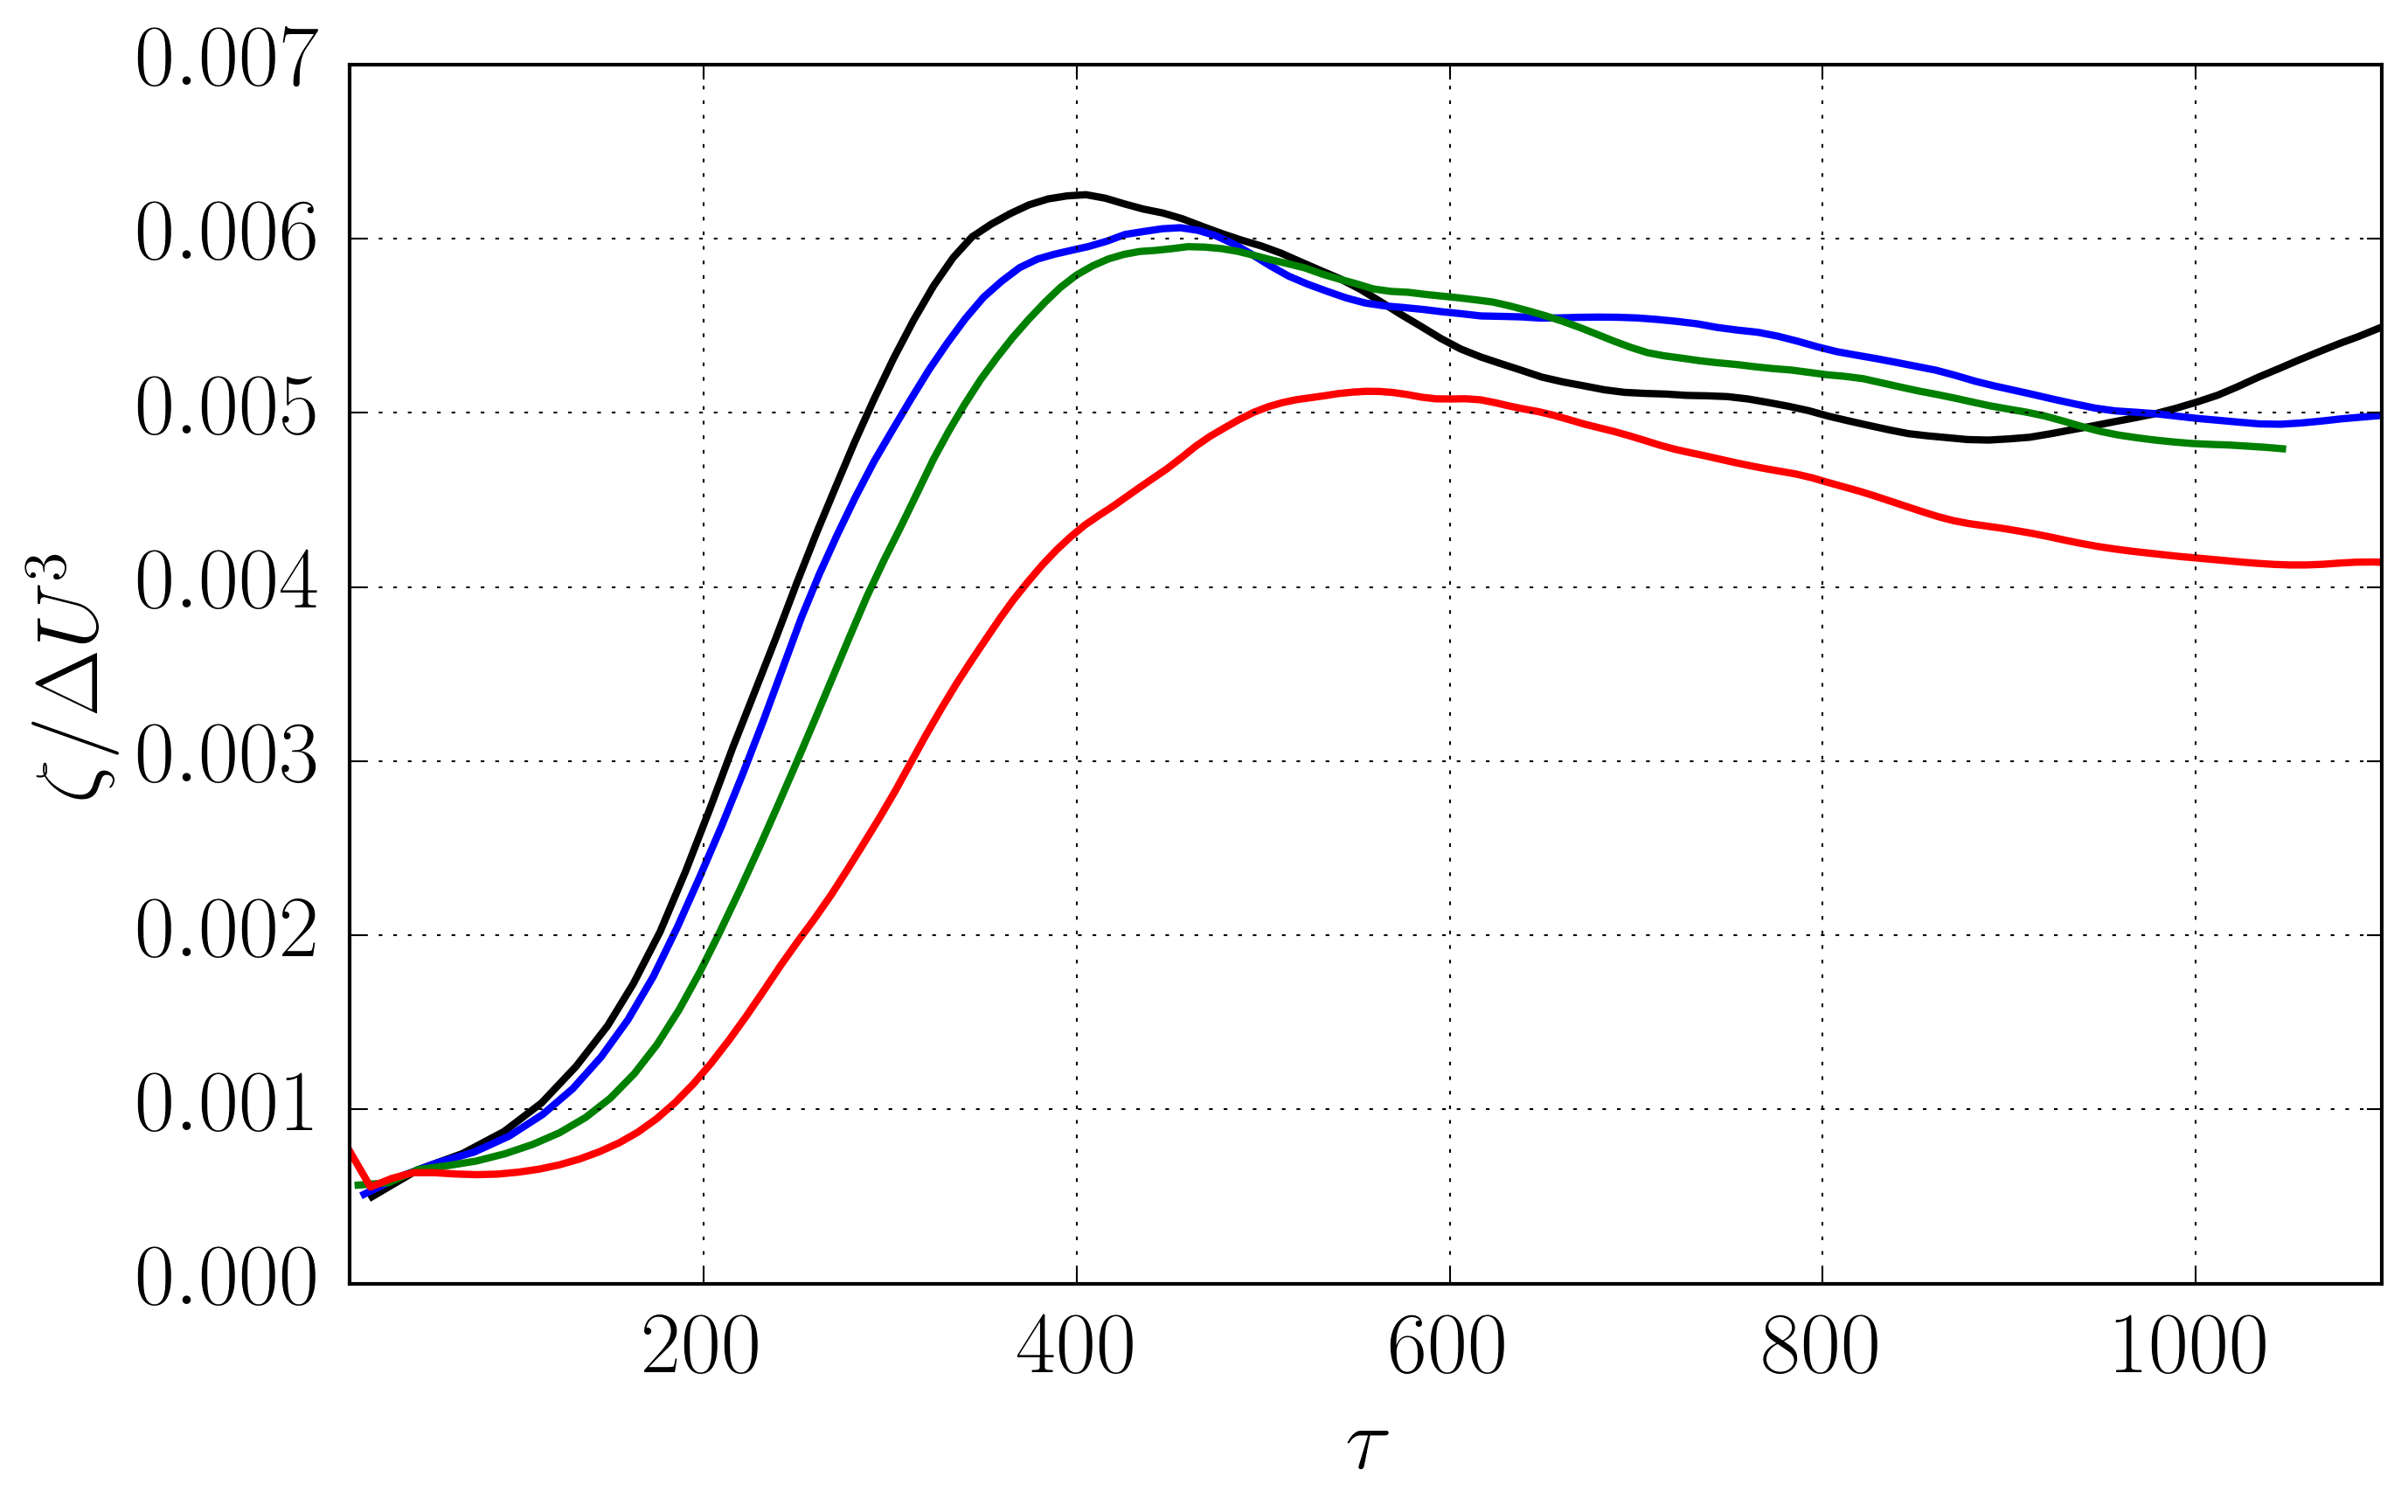

In [20]:
#Preparing plot
fig = plt.figure(figsize=(xlen,ylen)) #Define figure with size
ax=fig.add_subplot(1,1,1)
#Plot all jobs in the same graph
#time_int = np.linspace(tmin,tmax,Npoints)
tmaxjob = [0 for i in range(njobs)]
for ijob in range(njobs):
    path = p_folders[ijob]
    with h5py.File(path,"r") as f:
        time = np.array(f['time'])
        fun = np.array(f[variable] )
        #tmaxjob[ijob] = np.max(time)
        #ilim = where(time>tmaxcases[ijob])[0][0]
        #plt.plot(time[0:ilim] ,fun[0:ilim],l_job_style[ijob/3],lw=2.0)
        plt.plot(time ,fun,l_job_style[ijob],lw=2.0)
    #plt.plot(time_int,fun_ave2[case],l_job_style[case],lw=2.0,ls='dashed')
    #ax.fill_between(time_int, fun_ave[case], fun_ave2[case], where=fun_ave[case]>=fun_ave2[case], facecolor=l_job_color[case],alpha=0.2, interpolate=False)
    #ax.fill_between(time_int, 0, fun_ave2[case], where=fun_ave2[case]>0, facecolor=l_job_color[case],alpha=0.5, interpolate=False)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
#ax.set_ylim([0,7.0])
ax.set_xlim([10,tmax])
plt.grid('on')
#SAVING
#if PRINT == True:
#    print "figure saved!"
#    pathname = save_folder + 'epsvstime_ave' + fformat
#    fig.savefig(pathname,bbox_inches='tight')


# $\delta_m$ vs time

In [21]:
variable = 'dm'
#lcases = [[0],[1]]
#tmin=10; tmax=850;
xlabel=r'$\tau$'
ylabel=r'$\delta_m/\delta_m^0$'
fformat = '.pdf'
figname = 'dmvstime_ave'
ncases = len(lcases)
print njobs
#tmaxcases = [600,700]

4


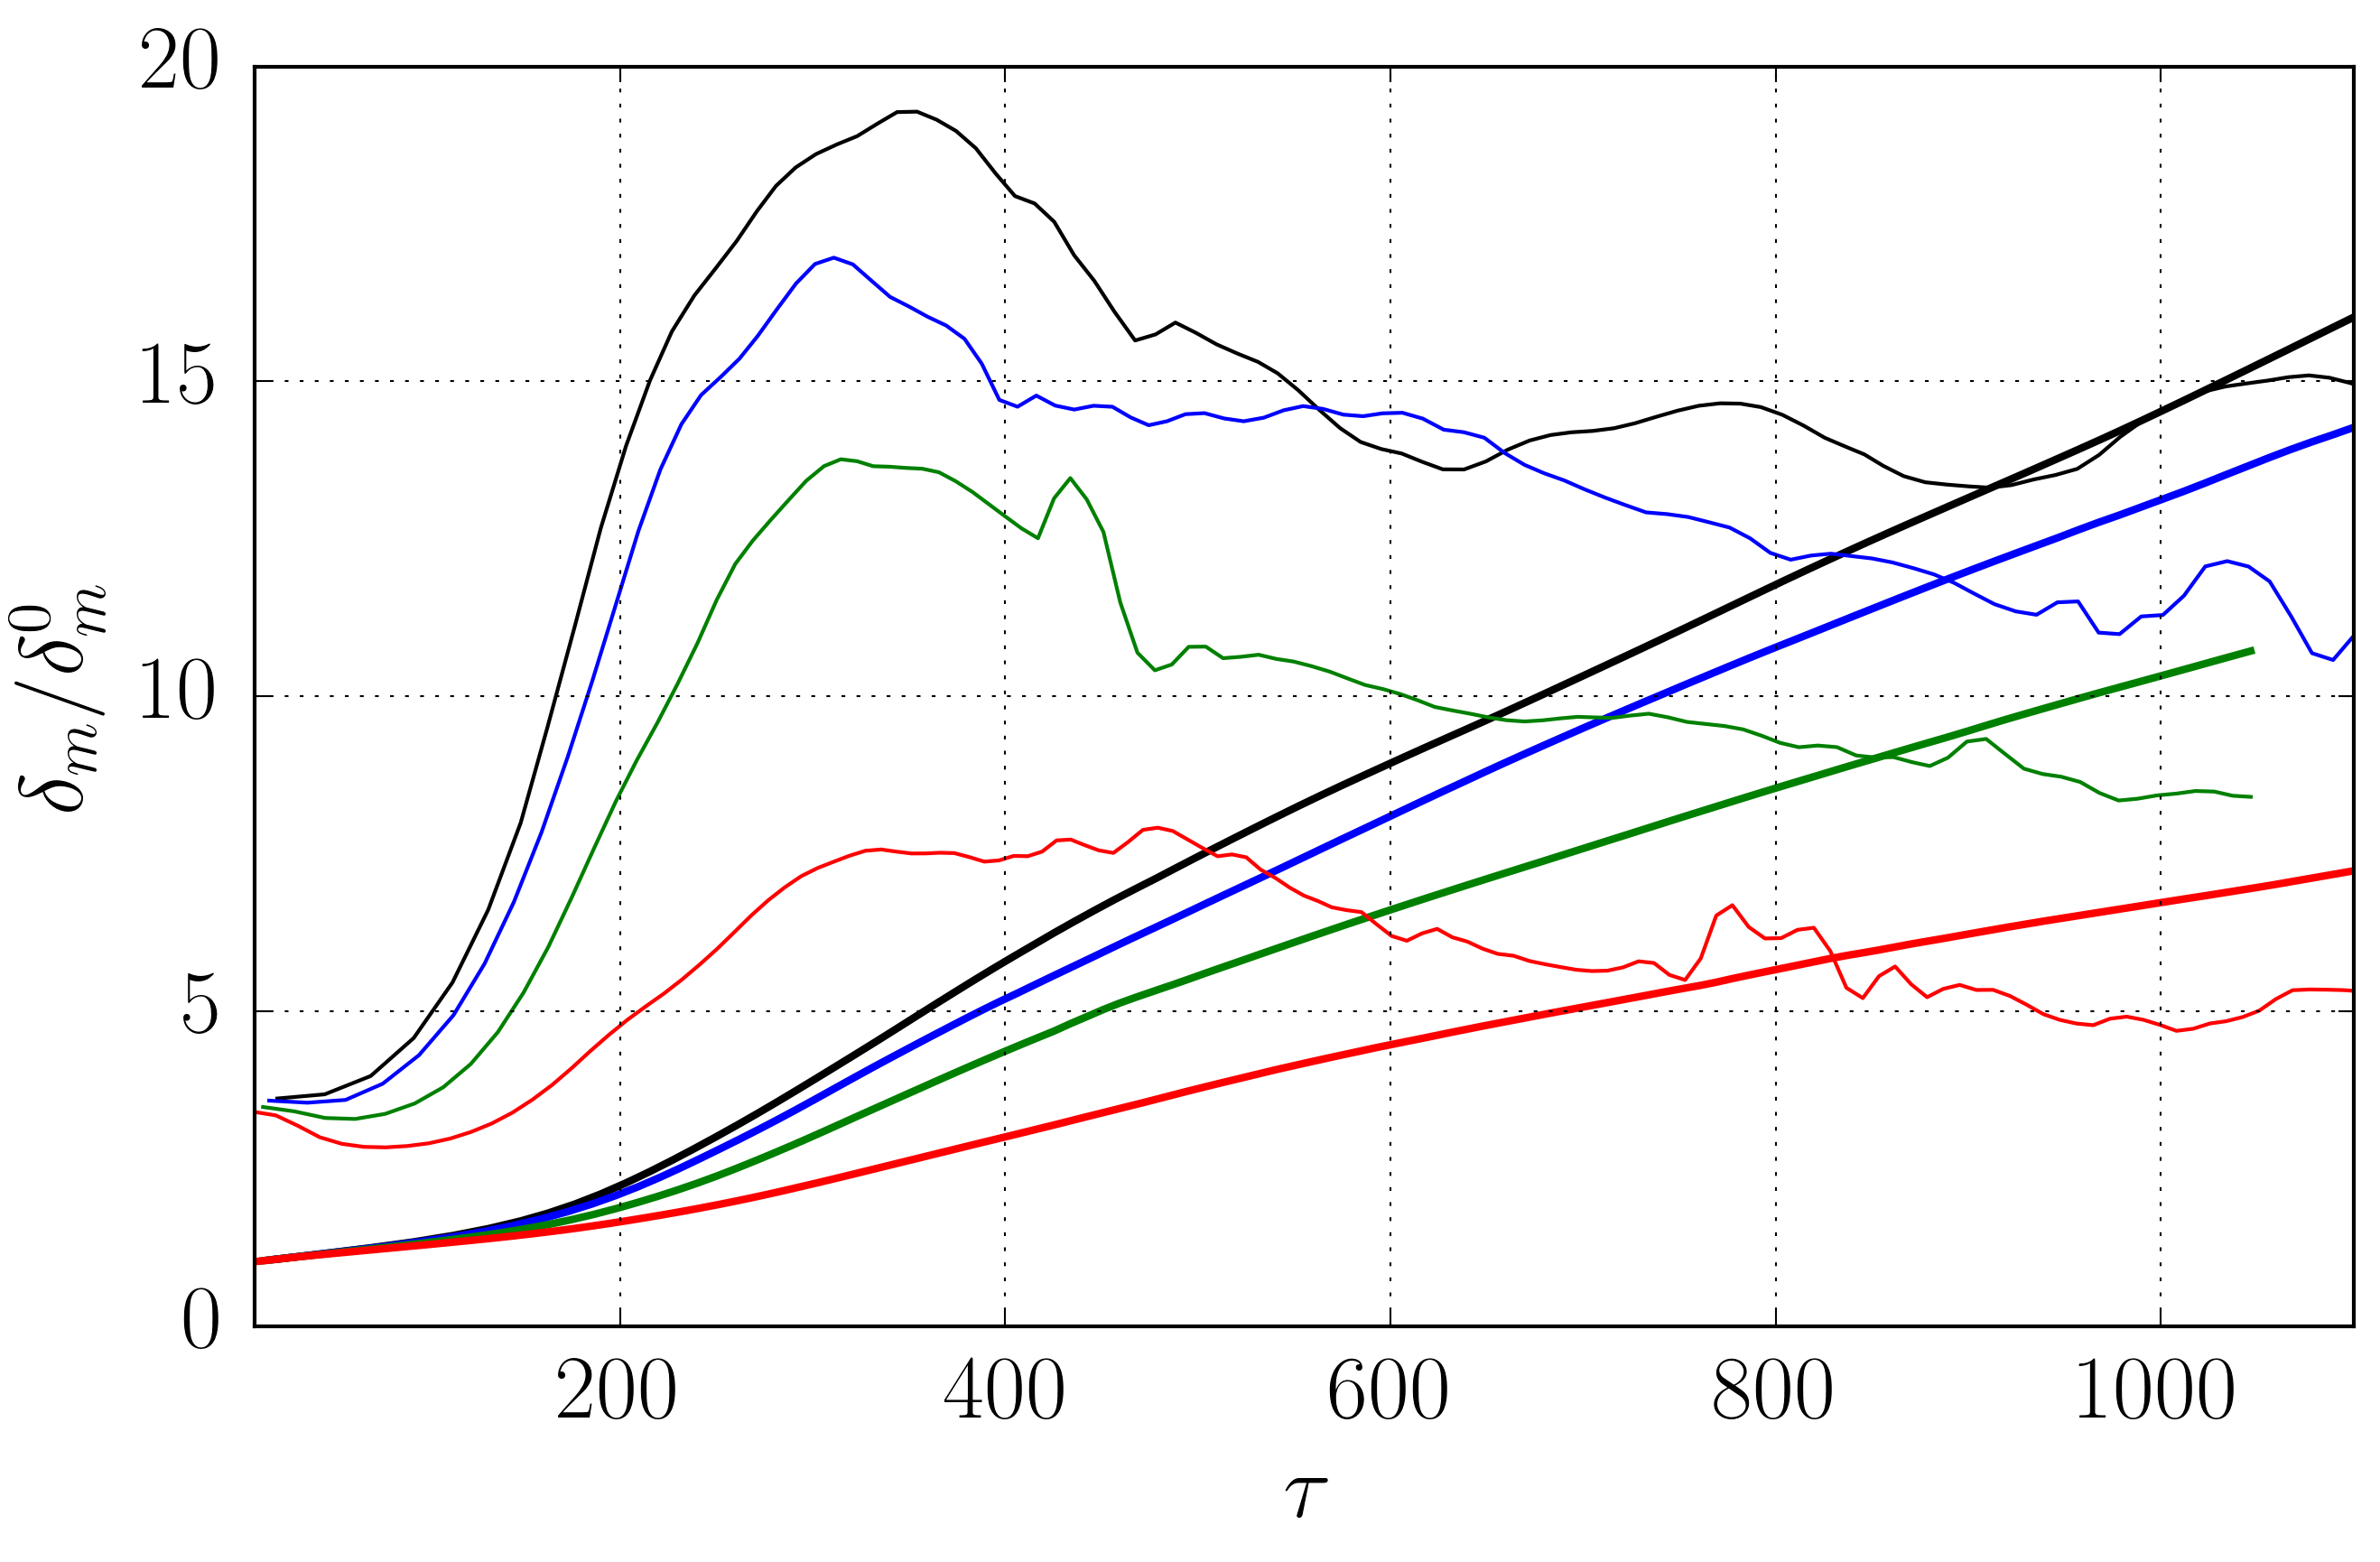

In [22]:
#Preparing plot
fig = plt.figure(figsize=(xlen,ylen)) #Define figure with size
ax=fig.add_subplot(1,1,1)
#Plot all jobs in the same graph
#time_int = np.linspace(tmin,tmax,Npoints)
tmaxjob = [0 for i in range(njobs)]
for ijob in range(njobs):
    path = p_folders[ijob]
    with h5py.File(path,"r") as f:
        time = np.array(f['time'])
        fun = np.array(f[variable] )
        #tmaxjob[ijob] = np.max(time)
        #ilim = where(time>tmaxcases[ijob])[0][0]
        #plt.plot(time[0:ilim] ,fun[0:ilim],l_job_style[ijob/3],lw=2.0)
        plt.plot(time ,fun,l_job_style[ijob],lw=2.0)
        plt.plot(time,1000*der1(time,fun),l_job_style[ijob])
    #plt.plot(time_int,fun_ave2[case],l_job_style[case],lw=2.0,ls='dashed')
    #ax.fill_between(time_int, fun_ave[case], fun_ave2[case], where=fun_ave[case]>=fun_ave2[case], facecolor=l_job_color[case],alpha=0.2, interpolate=False)
    #ax.fill_between(time_int, 0, fun_ave2[case], where=fun_ave2[case]>0, facecolor=l_job_color[case],alpha=0.5, interpolate=False)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
#ax.set_ylim([0,7.0])
ax.set_xlim([10,tmax])
plt.grid('on')
#SAVING
#if PRINT == True:
#    print "figure saved!"
#    pathname = save_folder + 'epsvstime_ave' + fformat
#    fig.savefig(pathname,bbox_inches='tight')


# $\delta_w$ vs time

In [26]:
variable = 'dw'
#lcases = [[0],[1]]
tmin=10; tmax=1200;
xlabel=r'$\tau$'
ylabel=r'$\delta_w$'
fformat = '.pdf'
figname = 'dwvstime_ave'
ncases = len(lcases)
print njobs
#tmaxcases = [600,700]

4


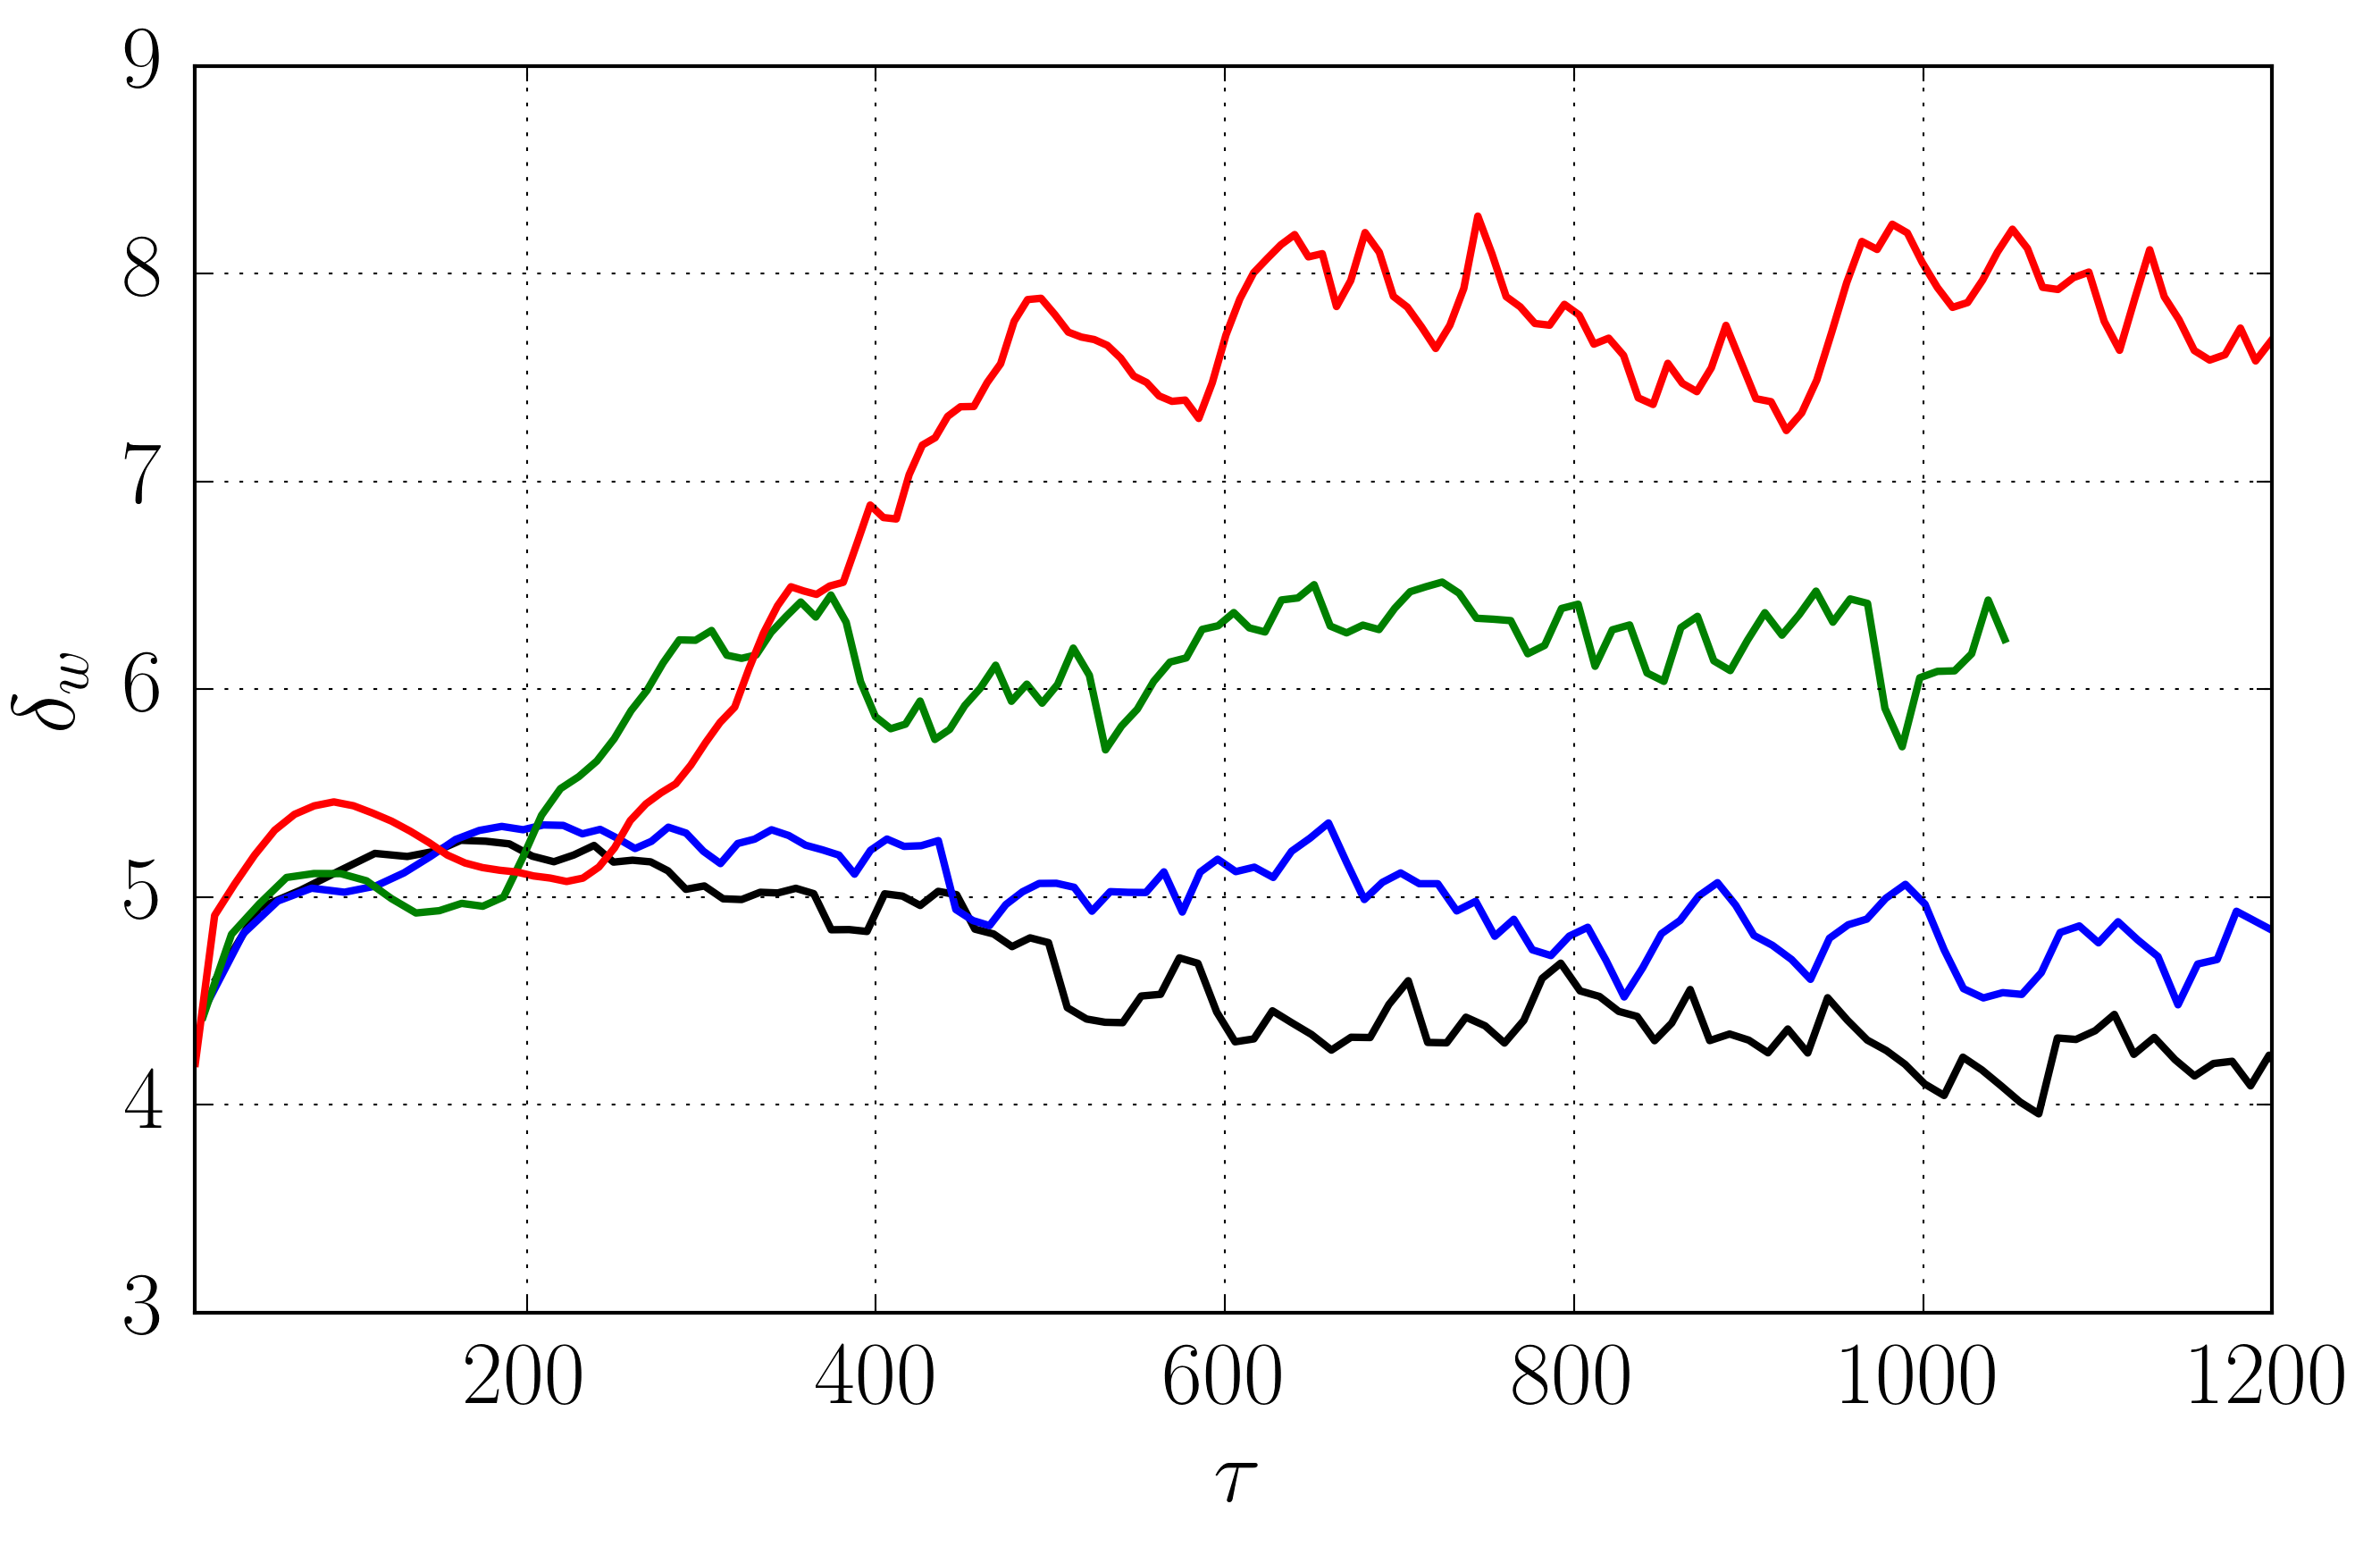

In [27]:
#Preparing plot
fig = plt.figure(figsize=(xlen,ylen)) #Define figure with size
ax=fig.add_subplot(1,1,1)
#Plot all jobs in the same graph
#time_int = np.linspace(tmin,tmax,Npoints)
tmaxjob = [0 for i in range(njobs)]
for ijob in range(njobs):
    path = p_folders[ijob]
    with h5py.File(path,"r") as f:
        time = np.array(f['time'])
        fun = np.array(f[variable] )
        fun2 = np.array(f['dm'] )
        #tmaxjob[ijob] = np.max(time)
        #ilim = where(time>tmaxcases[ijob])[0][0]
        #plt.plot(time[0:ilim] ,fun[0:ilim],l_job_style[ijob/3],lw=2.0)
        plt.plot(time ,fun/fun2,l_job_style[ijob],lw=2.0)
    #plt.plot(time_int,fun_ave2[case],l_job_style[case],lw=2.0,ls='dashed')
    #ax.fill_between(time_int, fun_ave[case], fun_ave2[case], where=fun_ave[case]>=fun_ave2[case], facecolor=l_job_color[case],alpha=0.2, interpolate=False)
    #ax.fill_between(time_int, 0, fun_ave2[case], where=fun_ave2[case]>0, facecolor=l_job_color[case],alpha=0.5, interpolate=False)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
#ax.set_ylim([0,7.0])
ax.set_xlim([10,tmax])
plt.grid('on')
#SAVING
#if PRINT == True:
#    print "figure saved!"
#    pathname = save_folder + 'epsvstime_ave' + fformat
#    fig.savefig(pathname,bbox_inches='tight')


In [28]:
variable = 'Relambda'
#lcases = [[0],[1]]
#tmin=10; tmax=820;
xlabel=r'$\tau$'
ylabel=r'$Re_\lambda$'
fformat = '.pdf'
figname = 'Relambdavstime_ave'
ncases = len(lcases)
print njobs
#tmaxcases = [600,700]

4


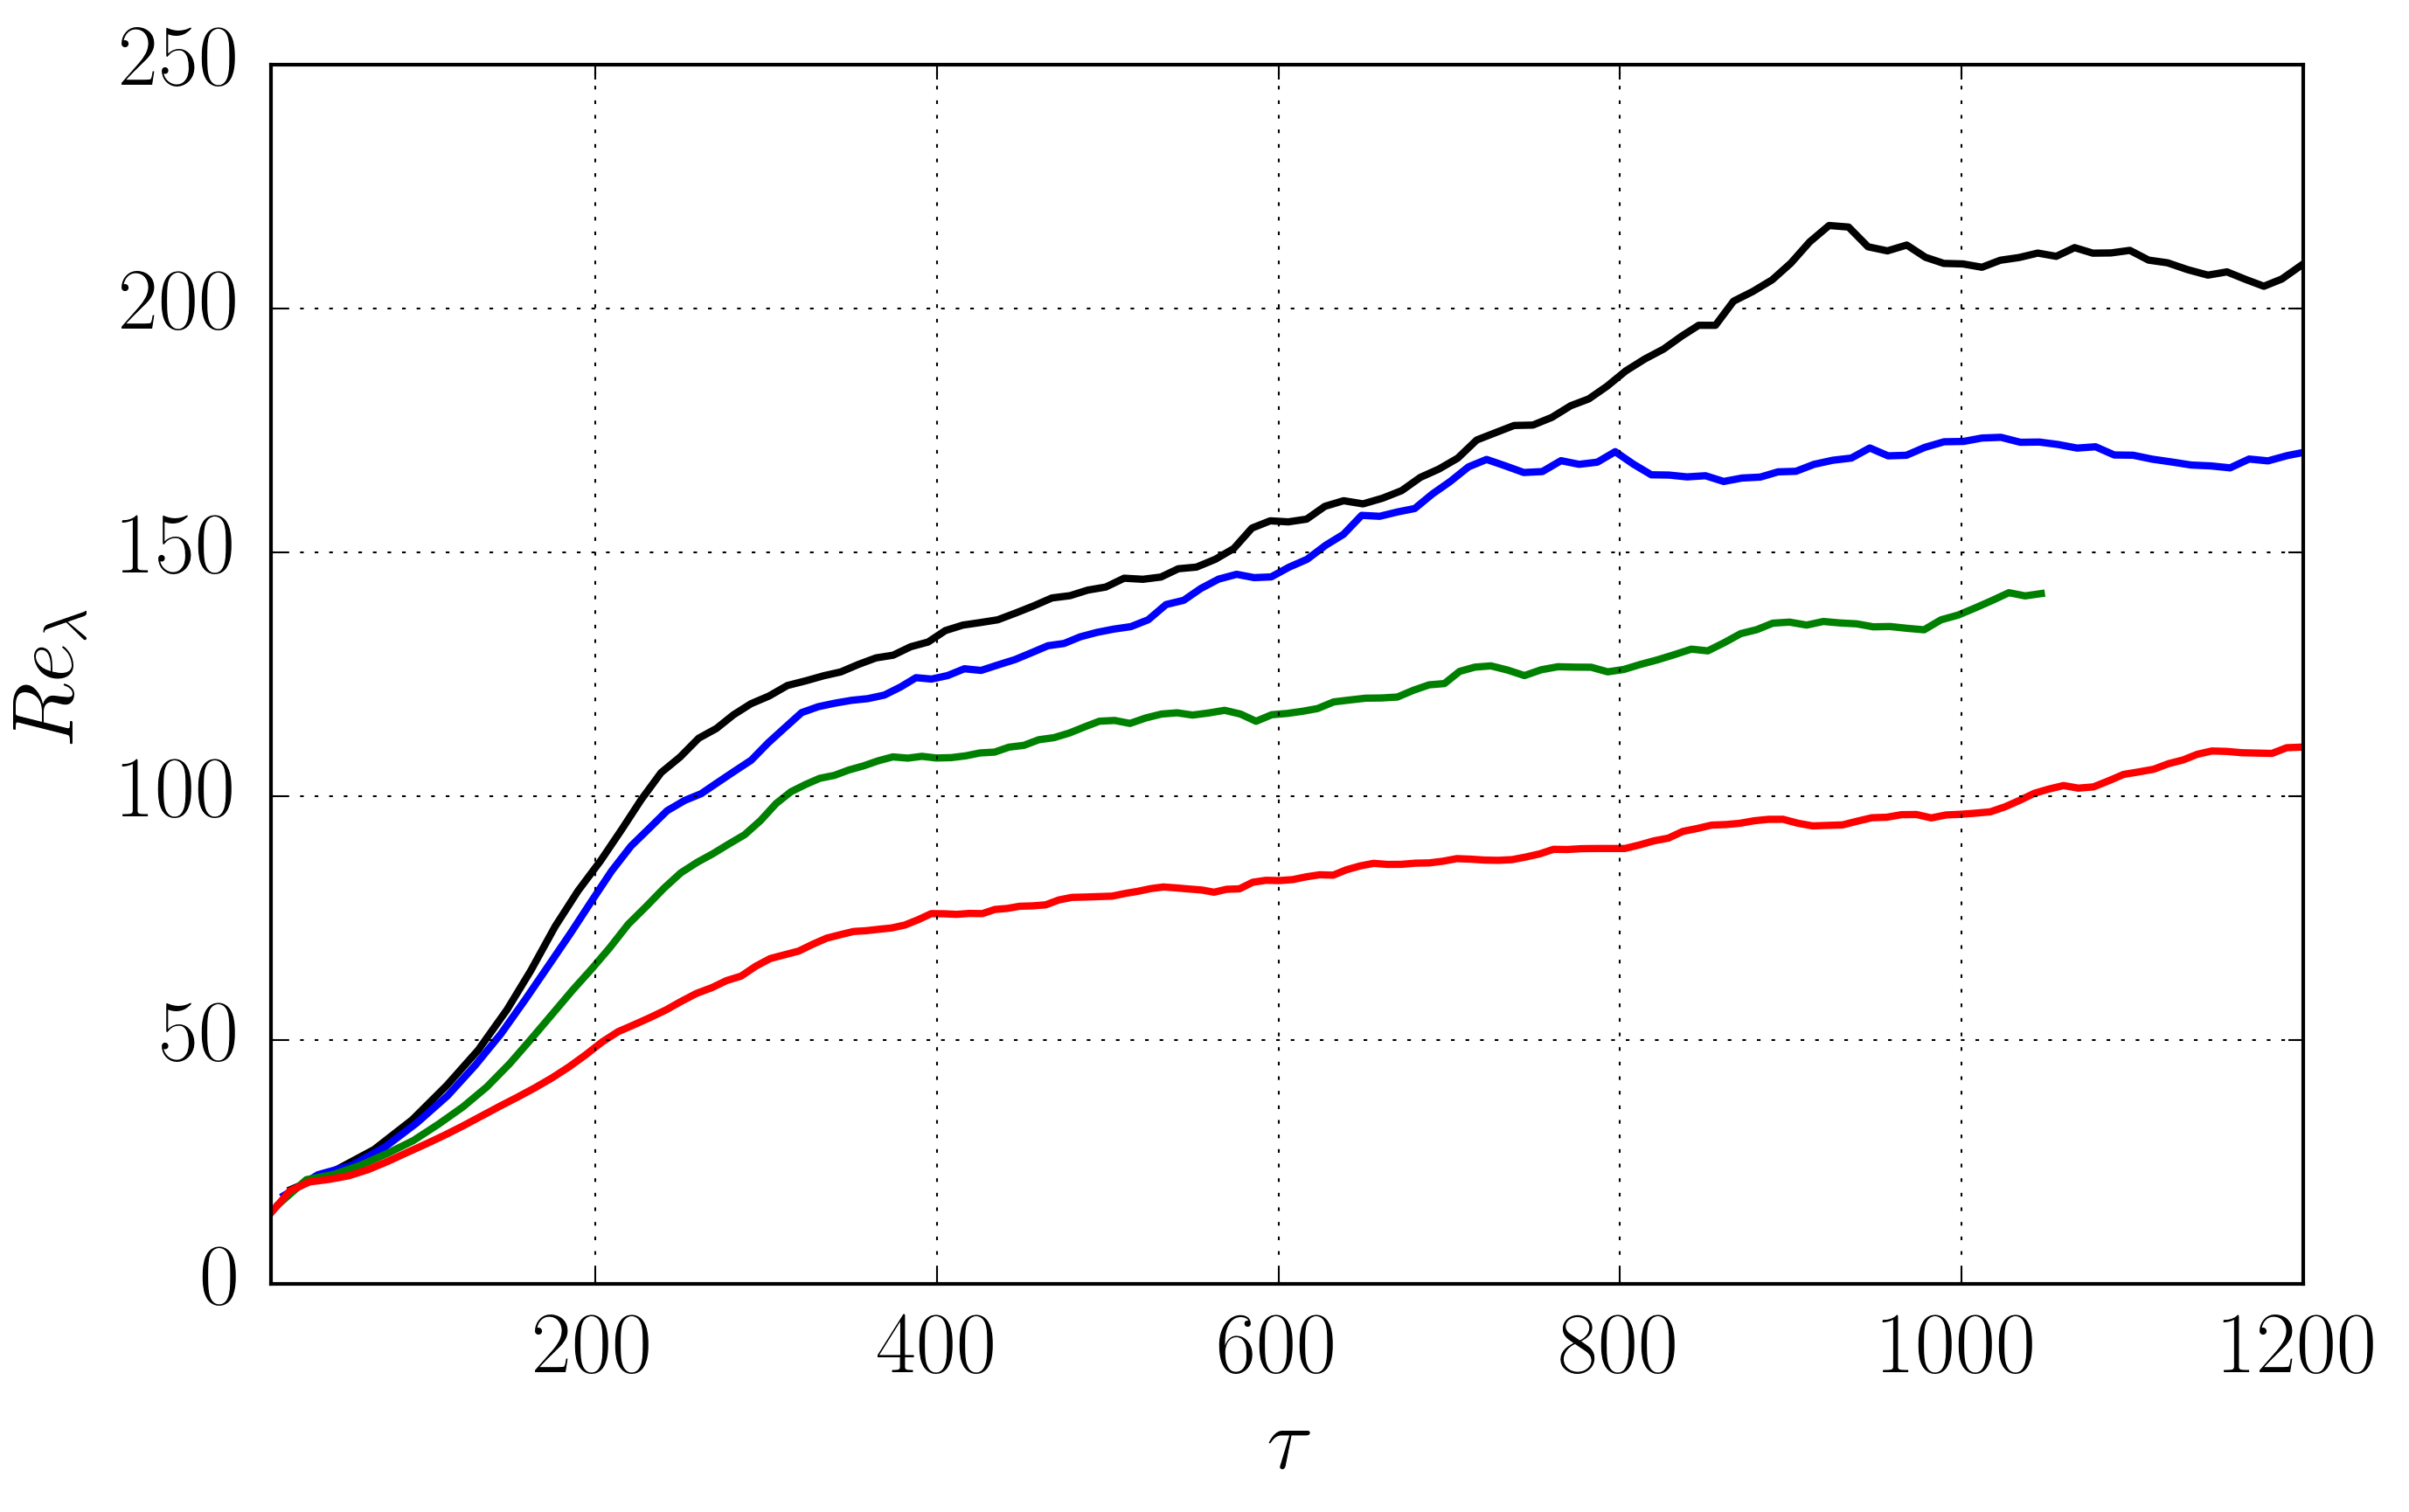

In [29]:
#Preparing plot
fig = plt.figure(figsize=(xlen,ylen)) #Define figure with size
ax=fig.add_subplot(1,1,1)
#Plot all jobs in the same graph
#time_int = np.linspace(tmin,tmax,Npoints)
tmaxjob = [0 for i in range(njobs)]
for ijob in range(njobs):
    path = p_folders[ijob]
    with h5py.File(path,"r") as f:
        time = np.array(f['time'])
        fun = np.array(f[variable] )
        #tmaxjob[ijob] = np.max(time)
        #ilim = where(time>tmaxcases[ijob])[0][0]
        #plt.plot(time[0:ilim] ,fun[0:ilim],l_job_style[ijob/3],lw=2.0)
        plt.plot(time ,fun,l_job_style[ijob],lw=2.0)
    #plt.plot(time_int,fun_ave2[case],l_job_style[case],lw=2.0,ls='dashed')
    #ax.fill_between(time_int, fun_ave[case], fun_ave2[case], where=fun_ave[case]>=fun_ave2[case], facecolor=l_job_color[case],alpha=0.2, interpolate=False)
    #ax.fill_between(time_int, 0, fun_ave2[case], where=fun_ave2[case]>0, facecolor=l_job_color[case],alpha=0.5, interpolate=False)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
#ax.set_ylim([0,7.0])
ax.set_xlim([10,tmax])
plt.grid('on')
#SAVING
#if PRINT == True:
#    print "figure saved!"
#    pathname = save_folder + 'epsvstime_ave' + fformat
#    fig.savefig(pathname,bbox_inches='tight')


In [30]:
variable = 'dmpoint'
#lcases = [[0],[1]]
#tmin=10; tmax=820;
xlabel=r'$\tau$'
ylabel=r'$\dot{\delta}_m$'
fformat = '.pdf'
figname = 'dmpointvstime'
ncases = len(lcases)
print njobs
#tmaxcases = [600,700]

4


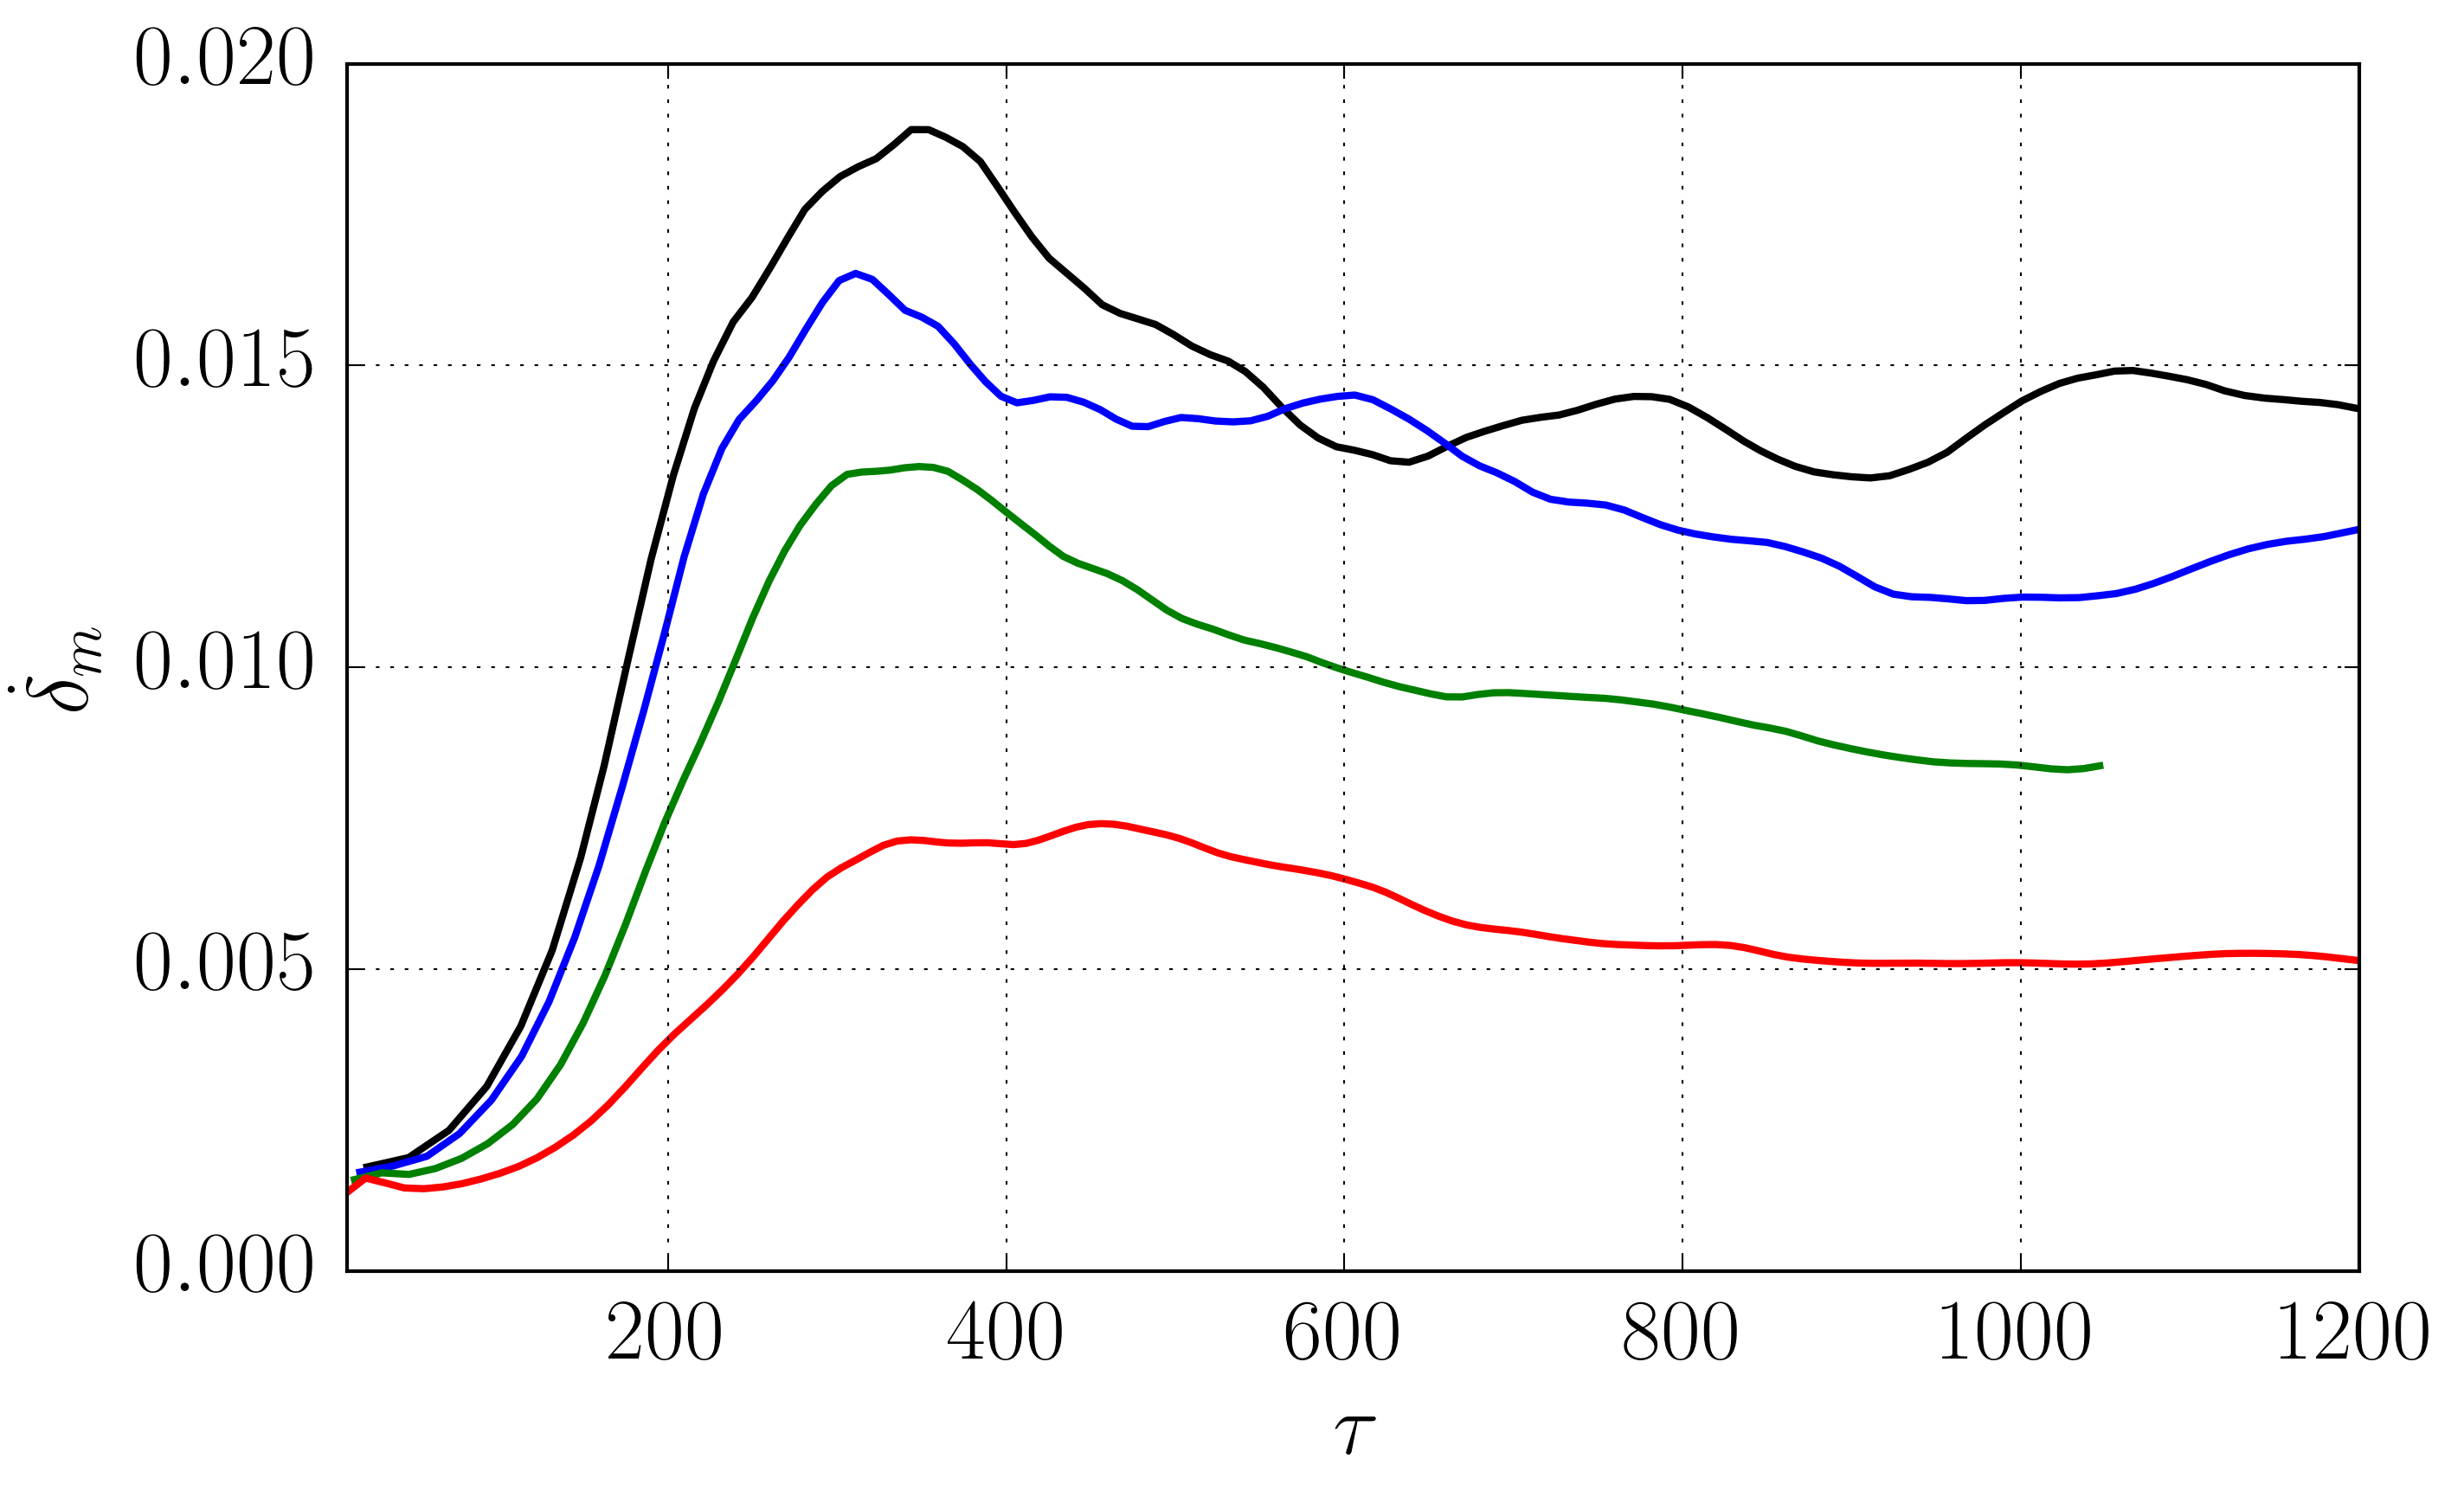

In [31]:
#Preparing plot
fig = plt.figure(figsize=(xlen,ylen)) #Define figure with size
ax=fig.add_subplot(1,1,1)
#Plot all jobs in the same graph
#time_int = np.linspace(tmin,tmax,Npoints)
tmaxjob = [0 for i in range(njobs)]
for ijob in range(njobs):
    path = p_folders[ijob]
    with h5py.File(path,"r") as f:
        time = np.array(f['time'])
        fun = np.array(f[variable] )
        #tmaxjob[ijob] = np.max(time)
        #ilim = where(time>tmaxcases[ijob])[0][0]
        #plt.plot(time[0:ilim] ,fun[0:ilim],l_job_style[ijob/3],lw=2.0)
        plt.plot(time ,fun,l_job_style[ijob],lw=2.0)
    #plt.plot(time_int,fun_ave2[case],l_job_style[case],lw=2.0,ls='dashed')
    #ax.fill_between(time_int, fun_ave[case], fun_ave2[case], where=fun_ave[case]>=fun_ave2[case], facecolor=l_job_color[case],alpha=0.2, interpolate=False)
    #ax.fill_between(time_int, 0, fun_ave2[case], where=fun_ave2[case]>0, facecolor=l_job_color[case],alpha=0.5, interpolate=False)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
#ax.set_ylim([0,7.0])
ax.set_xlim([10,tmax])
plt.grid('on')
#SAVING
#if PRINT == True:
#    print "figure saved!"
#    pathname = save_folder + 'epsvstime_ave' + fformat
#    fig.savefig(pathname,bbox_inches='tight')


/share/drive/toni/VDML/JFM/R33contours1run0.pdf


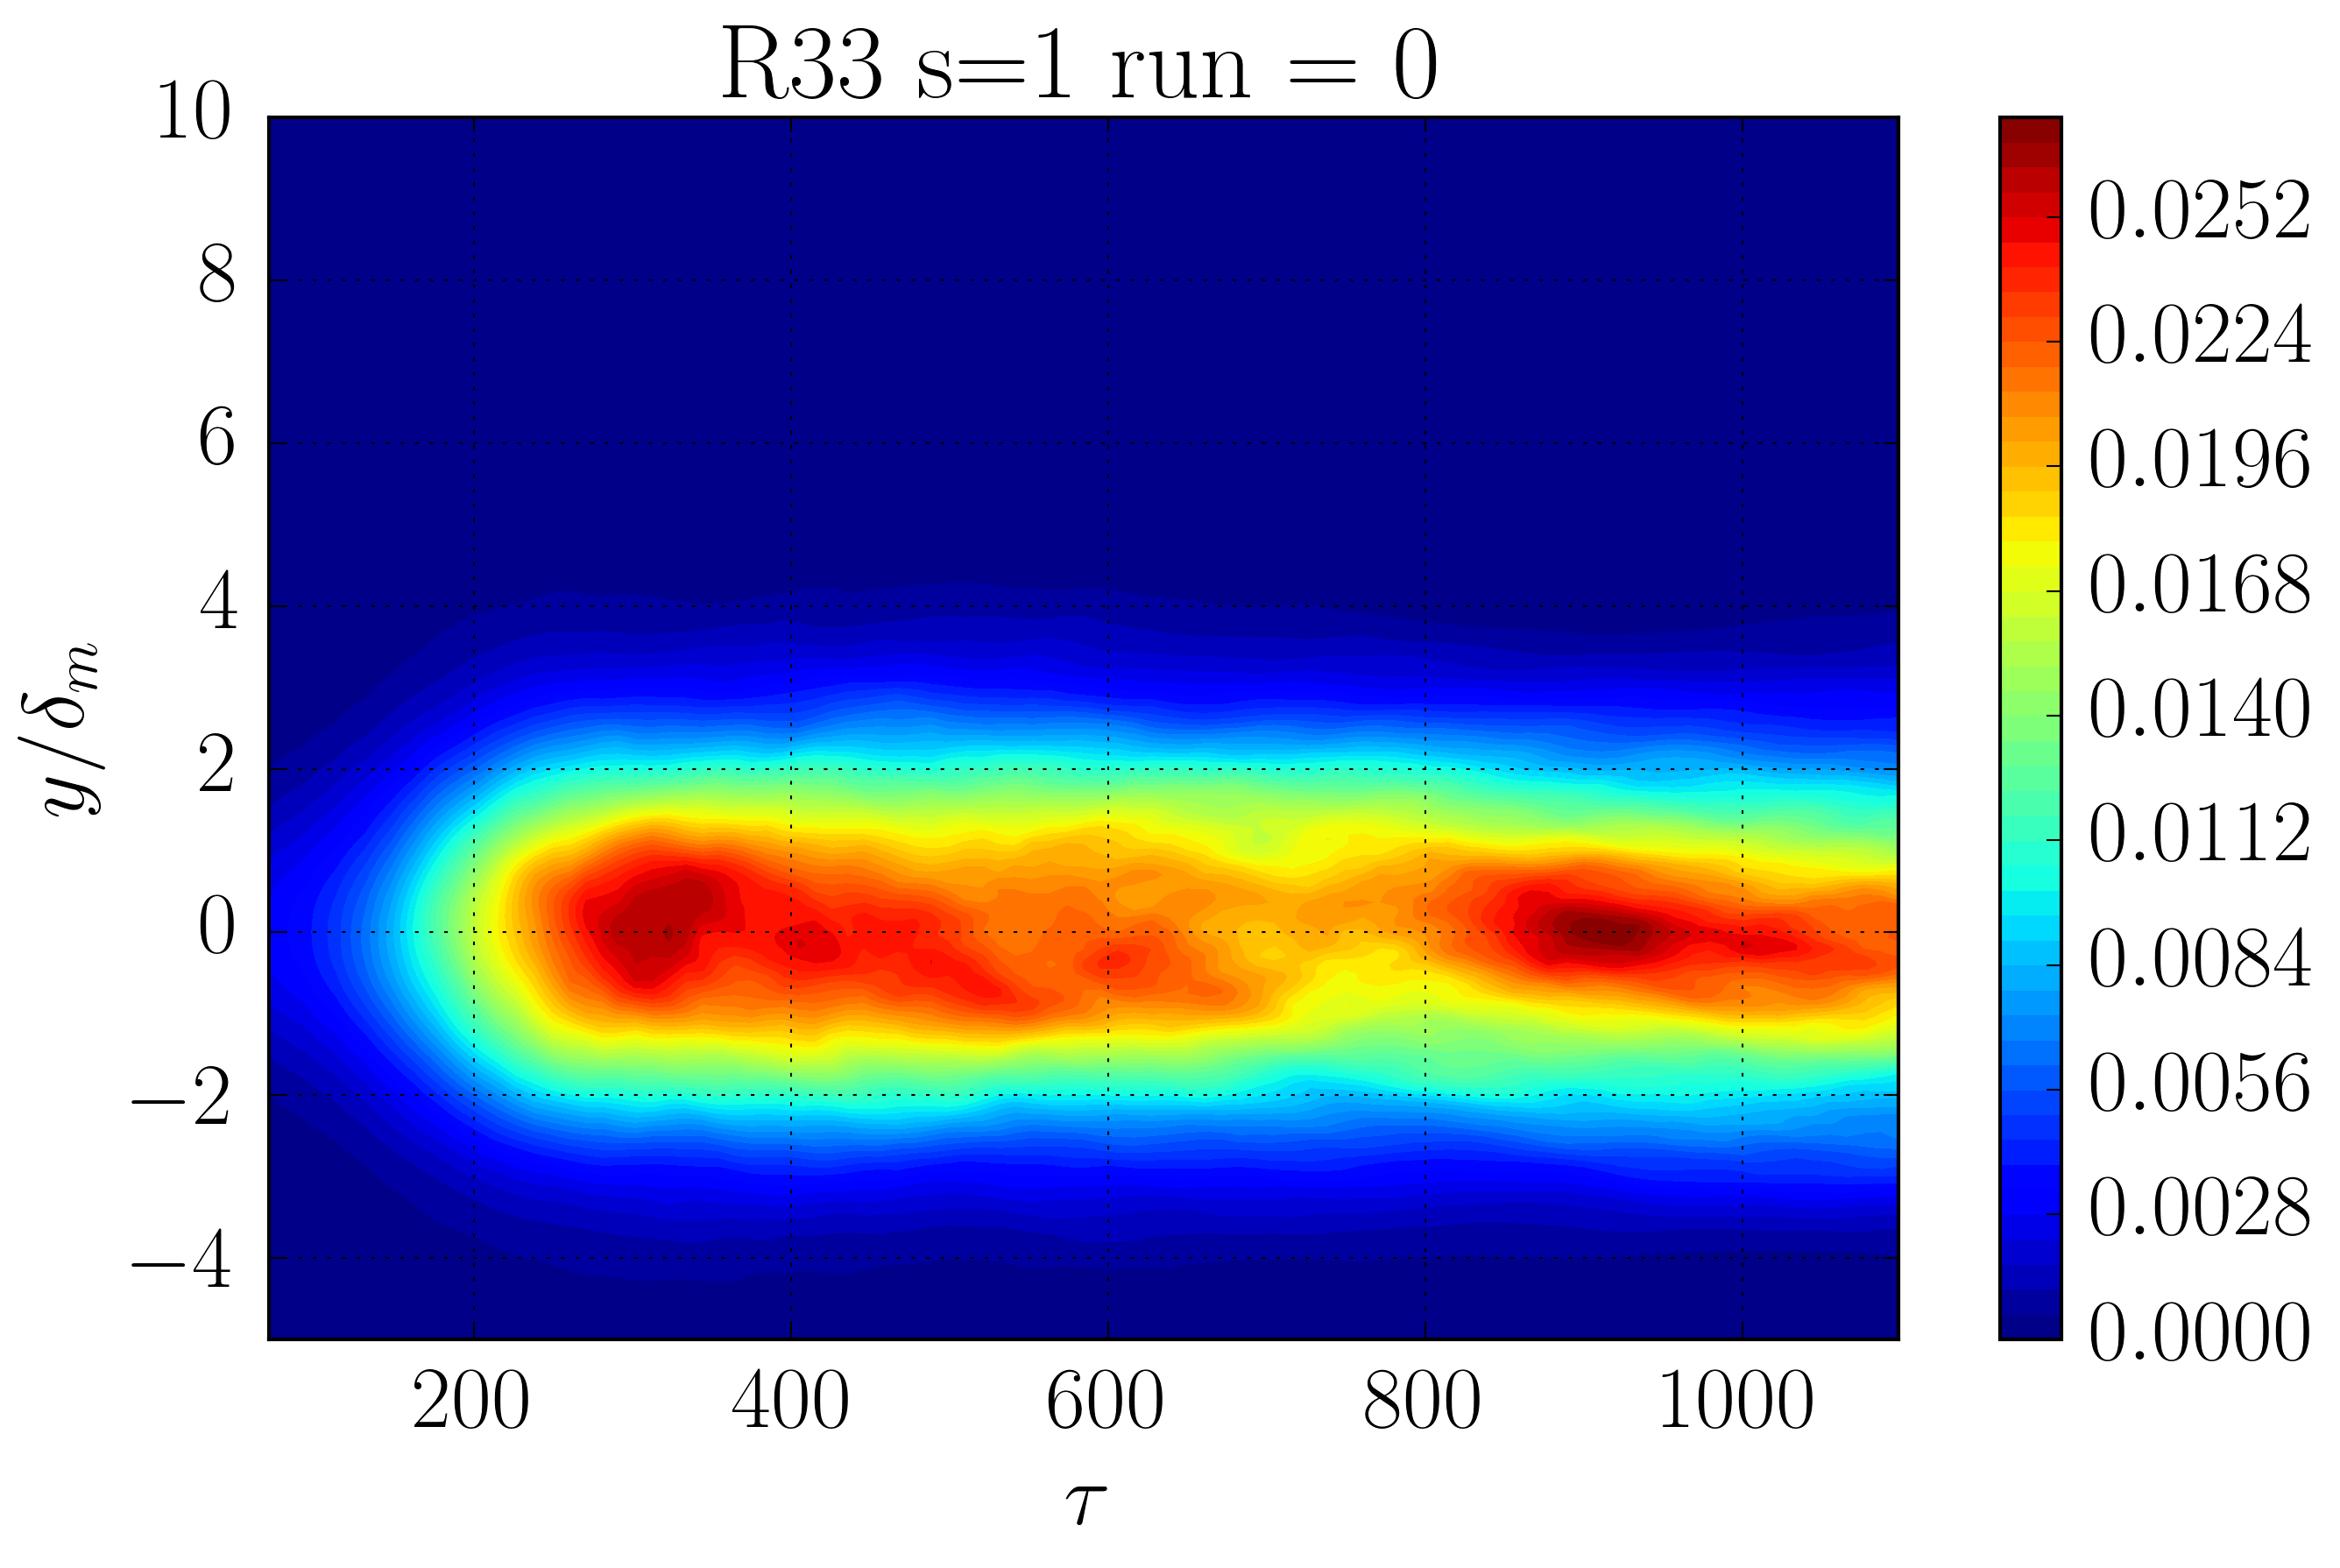

In [42]:
fformat='.pdf'
scase = 1
jlist= [0] #s=8
#jlist= [6,7,8] #s=4
jjob=0
variable='R33'
PRINT=True
tmin=50
tmax = 1100

jlist2=[jlist[jjob]]
figname = variable+'contours%srun%s'%(scase,jlist2[0])
scaling = 'dm'
#jlist = [0,1,2] #s=1
#jlist= [3,4,5] #s=2
#jlist= [6,7,8] #s=4
fig = plt.figure(figsize=(xlen,ylen)) #Define figure with size
ax=fig.add_subplot(1,1,1)
for ijob in jlist2:
    #t11 = SS1[ijob]; t12 = SS2[ijob]; 
    t11 = tmin; t12 = tmax; 
    #print t11,t12
    yxi,timef,ff = pcolorintime(p_folders[ijob],variable,t11,t12,scaling)
    
    #one before SS
#plt.contour(timef,yxi,np.transpose(ff),100,shading='flat')
NC=50
plt.contourf(timef,yxi,np.transpose(ff),np.linspace(np.min(ff),np.max(ff),NC))
plt.ylim([-5,10])
plt.ylabel(r'$y/\delta_m$')
plt.xlabel(r'$\tau$')
plt.grid('on')
plt.colorbar()
stitle="%s s=%s run = %s" % (variable,scase,jlist2[0])
plt.title(stitle)
if PRINT == True:
    pathname = save_folder + figname+ fformat
    print pathname
    fig.savefig(pathname,bbox_inches='tight')
ff1= ff
yxi1=yxi

/share/drive/toni/VDML/JFM/R22contours8run3.pdf


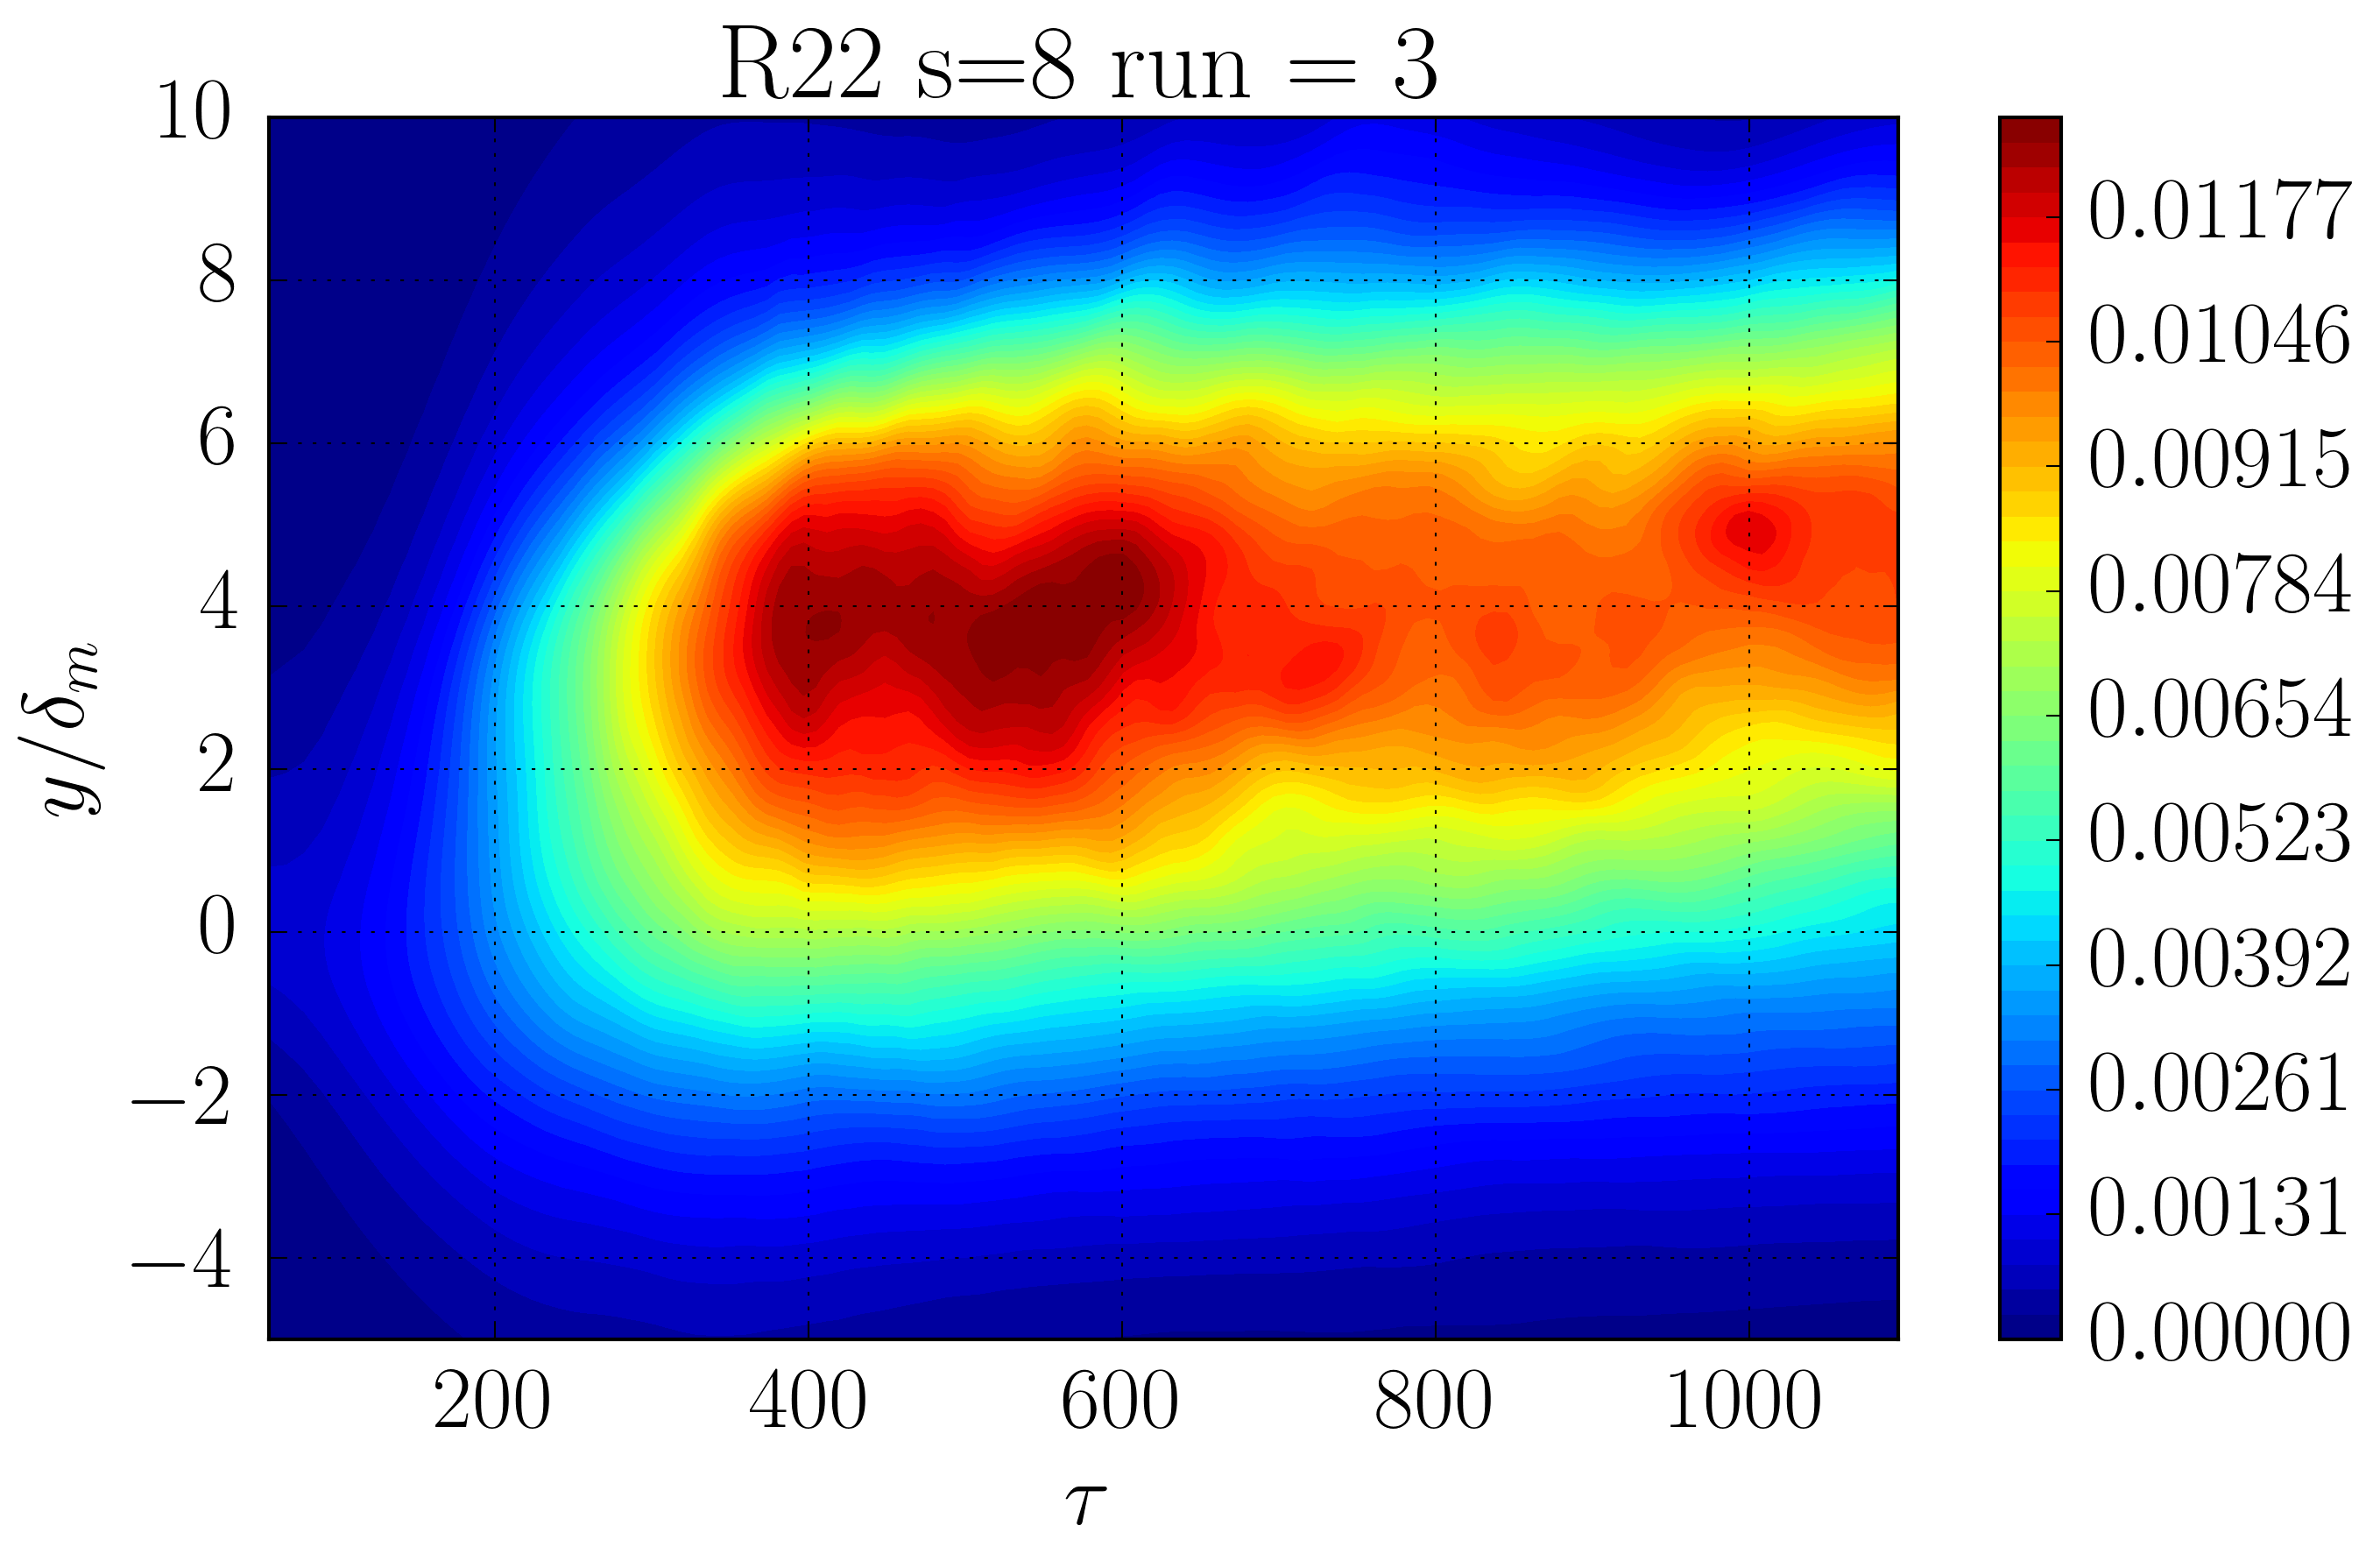

In [39]:
fformat='.pdf'
scase = 8
jlist= [3] #s=8
#jlist= [6,7,8] #s=4
jjob=0
variable='R22'
PRINT=True
tmin=50
tmax = 1100

jlist2=[jlist[jjob]]
figname = variable+'contours%srun%s'%(scase,jlist2[0])
scaling = 'dm'
#jlist = [0,1,2] #s=1
#jlist= [3,4,5] #s=2
#jlist= [6,7,8] #s=4
fig = plt.figure(figsize=(xlen,ylen)) #Define figure with size
ax=fig.add_subplot(1,1,1)
for ijob in jlist2:
    #t11 = SS1[ijob]; t12 = SS2[ijob]; 
    t11 = tmin; t12 = tmax; 
    #print t11,t12
    yxi,timef,ff = pcolorintime(p_folders[ijob],variable,t11,t12,scaling)
    
    #one before SS
#plt.contour(timef,yxi,np.transpose(ff),100,shading='flat')
NC=50
plt.contourf(timef,yxi,np.transpose(ff),np.linspace(np.min(ff),np.max(ff),NC))
plt.ylim([-5,10])
plt.ylabel(r'$y/\delta_m$')
plt.xlabel(r'$\tau$')
plt.grid('on')
plt.colorbar()
stitle="%s s=%s run = %s" % (variable,scase,jlist2[0])
plt.title(stitle)
if PRINT == True:
    pathname = save_folder + figname+ fformat
    print pathname
    fig.savefig(pathname,bbox_inches='tight')
ff1= ff
yxi1=yxi

/share/drive/toni/VDML/JFM/R12contours8run3.pdf


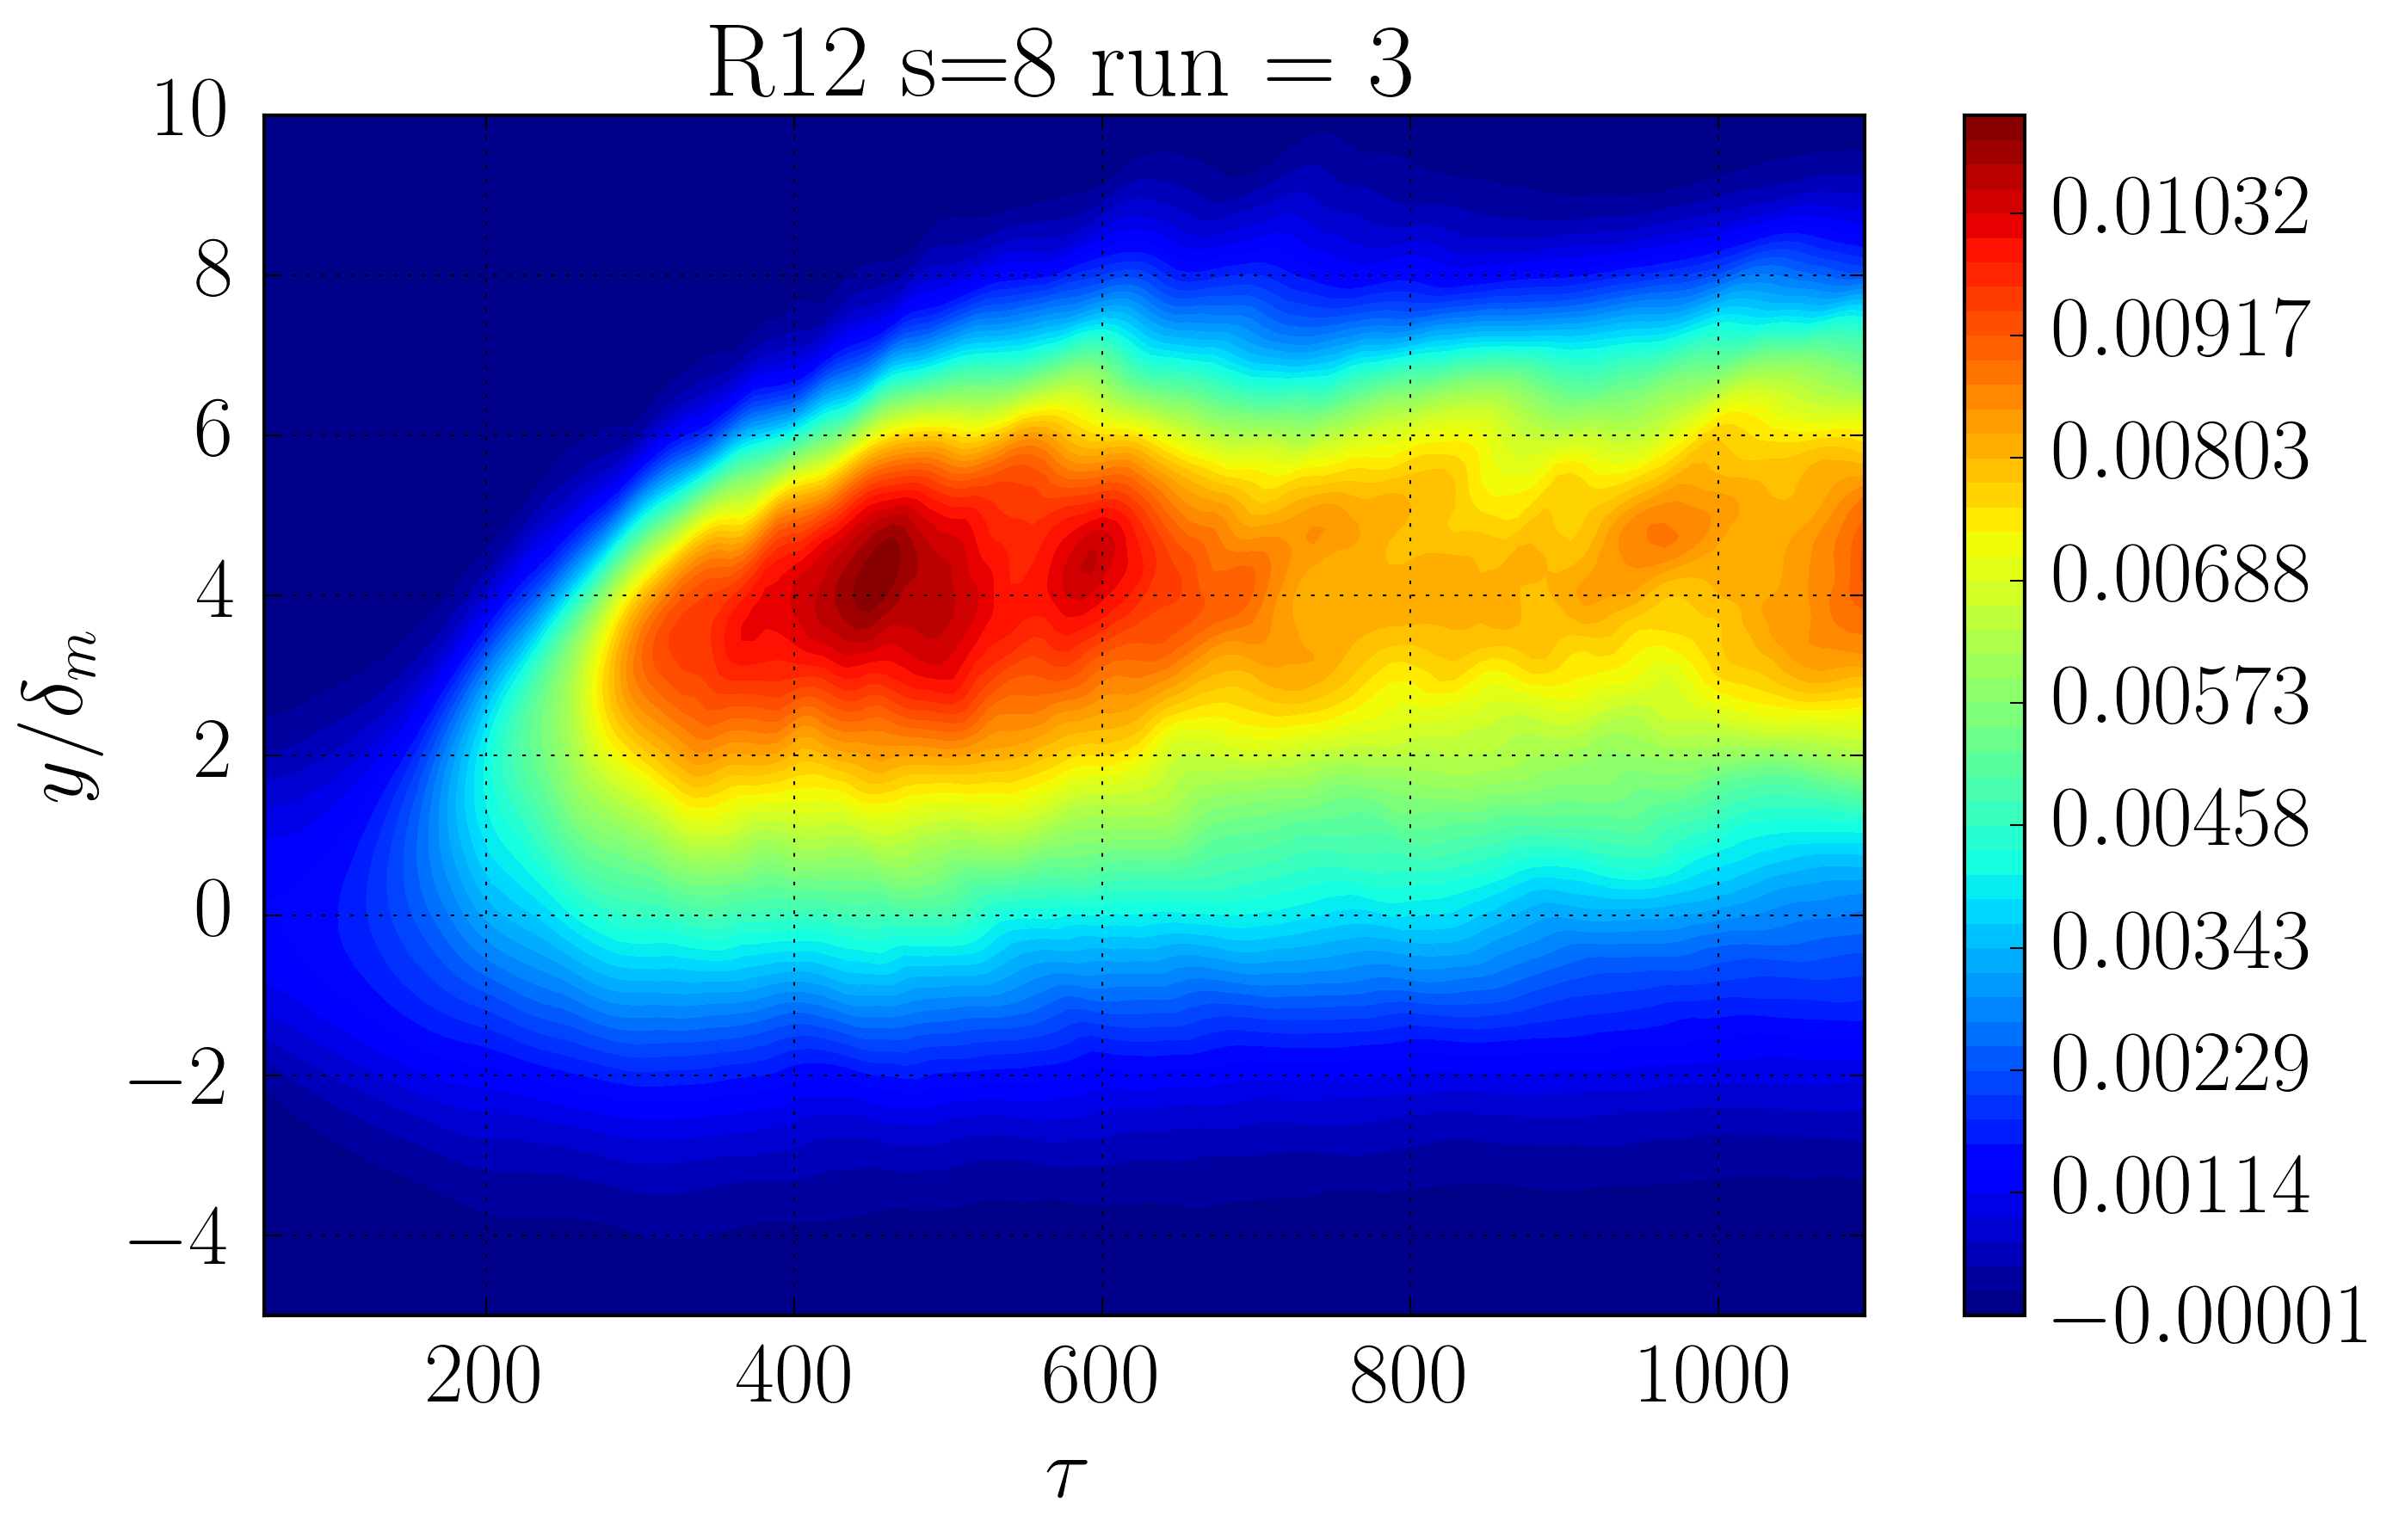

In [43]:
fformat='.pdf'
scase = 8
jlist= [3] #s=8
#jlist= [6,7,8] #s=4
jjob=0
variable='R12'
PRINT=True
tmin=50
tmax = 1100

jlist2=[jlist[jjob]]
figname = variable+'contours%srun%s'%(scase,jlist2[0])
scaling = 'dm'
#jlist = [0,1,2] #s=1
#jlist= [3,4,5] #s=2
#jlist= [6,7,8] #s=4
fig = plt.figure(figsize=(xlen,ylen)) #Define figure with size
ax=fig.add_subplot(1,1,1)
for ijob in jlist2:
    #t11 = SS1[ijob]; t12 = SS2[ijob]; 
    t11 = tmin; t12 = tmax; 
    #print t11,t12
    yxi,timef,ff = pcolorintime(p_folders[ijob],variable,t11,t12,scaling)
    
    #one before SS
#plt.contour(timef,yxi,np.transpose(ff),100,shading='flat')
NC=50
plt.contourf(timef,yxi,np.transpose(ff),np.linspace(np.min(ff),np.max(ff),NC))
plt.ylim([-5,10])
plt.ylabel(r'$y/\delta_m$')
plt.xlabel(r'$\tau$')
plt.grid('on')
plt.colorbar()
stitle="%s s=%s run = %s" % (variable,scase,jlist2[0])
plt.title(stitle)
if PRINT == True:
    pathname = save_folder + figname+ fformat
    print pathname
    fig.savefig(pathname,bbox_inches='tight')
ff1= ff
yxi1=yxi